# Visualisation and Intercomparison of GNSS In-Situ ZTD and IWV Time Series
**Hugo Breton**<sup>1</sup> *(breton@ipgp.fr)*  
**Olivier Bock**<sup>1</sup> *(bock@ipgp.fr)*  
<sup>1</sup>*Institut de Physique du Globe de Paris (IPGP)*  

Notebook developped in *April 2025*

---

In this notebook, we show how to **download** and **concatenate** files served by the CDS for the dataset **`insitu-observations-gnss`**.  More information about the dataset can be found on the [Copernicus Climate Data Store for GNSS Tropospheric Product](https://cds.climate.copernicus.eu/datasets/insitu-observations-gnss?tab=overview) website.
The script allows to visualise and intercompare time series from **IGS-daily** and **IGS-repro3** GNSS datasets available on CDS, both in ***ZTD and IWV units***, and compare ***GNSS IWV to ERA5 IWV estimates***.

Visualisation functions are stored in the `visualisation_functions.py` module.

We use the following Python libraries:
- `xarray`
- `numpy`
- `pandas`
- `seaborn`
- `matplotlib`

> **Note**: [`cads-api-client`](https://pypi.org/project/cads-api-client/) is now deprecated. Please use [`cdsapi`](https://pypi.org/project/cdsapi/) instead and ensure you have created a `.cdsapirc` file in your home directory with your CDS API key and URL (see [CDS API documentation](https://cds.climate.copernicus.eu/how-to-api)).

Functions used in this notebook are maintained on GitHub:  
🔗 [https://github.com/ipgpbreton/GNSS_intercomparison.git](https://github.com/ipgpbreton/GNSS_intercomparison.git)


In [18]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import cdsapi
import os
from pathlib import Path

import importlib
import visualisation_functions as vf
importlib.reload(vf)

<module 'visualisation_functions' from '/home/hbreton/Documents/Script/EGU2025_Cours/GNSS_intercomparison/visualisation_functions.py'>

# C3S API Request

The GNSS data used in this analysis is available from the Copernicus Climate Data Store (CDS). Access the dataset through the [CDS GNSS Observations Portal](https://cds.climate.copernicus.eu/datasets/insitu-observations-gnss?tab=download).

In [2]:
variable = "total_column_water_vapour_era5"  # zenith_total_delay or total_column_water_vapour or total_column_water_vapour_era5
starting_year, ending_year = 1996, 2014
network_type = "epn_repro2"  # igs_repro3 or igs_daily or epn_repro2

In [91]:
custom_base = input(
    "Enter base directory to save files (leave empty to use current folder): "
).strip()
base_dir = Path(custom_base) if custom_base else Path.cwd()
base_dir = base_dir / "Datas" / "EGU2025"  # /home/hbreton/Documents

In [ ]:
client = cdsapi.Client()

In [ ]:
dataset = "insitu-observations-gnss"
for year in range(starting_year, ending_year + 1):
    year_str = str(year)
    request = {
        "network_type": network_type,
        "variable": [variable],
        "year": year_str,
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],
        "format": "netcdf",
    }
    file_path = f"{base_dir}/{year_str}/{variable}_{network_type}_{year_str}.nc"

    if os.path.exists(file_path):
        print(f"File already exists: {file_path}. Skipping download.")
    else:
        try:
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            client.retrieve(dataset, request, target=file_path)
            print(f"Download successful for {year_str}")
        except Exception as e:
            print(f"Error during download for {year_str}: {e}")

# Concatenation of the yearly files

In [5]:
datasets = []
for year in range(starting_year, ending_year + 1):
    file_path = f"/{base_dir}/{year}/{variable}_{network_type}_{year}.nc"
    if os.path.exists(file_path):
        cadsobs_dataset = xr.open_dataset(file_path, engine="netcdf4")
        cadsobs_dataset.observed_variable.to_index().unique()
        cadsobs_dataset[
            "observed_variable"
        ] = cadsobs_dataset.observed_variable.str.decode("UTF-8")
        df_cadsobs_dataset = (
            cadsobs_dataset.to_dataframe()
            .set_index(["primary_station_id", "observed_variable"], inplace=False)
            .sort_index(level="primary_station_id")
        )
        datasets.append(df_cadsobs_dataset)
        print(f"Dataset loaded for {year}: {file_path}")
    else:
        print(f"File not found: {file_path}")

Dataset loaded for 1996: //home/hbreton/Documents/Datas/EGU2025/1996/total_column_water_vapour_era5_epn_repro2_1996.nc
Dataset loaded for 1997: //home/hbreton/Documents/Datas/EGU2025/1997/total_column_water_vapour_era5_epn_repro2_1997.nc
Dataset loaded for 1998: //home/hbreton/Documents/Datas/EGU2025/1998/total_column_water_vapour_era5_epn_repro2_1998.nc
Dataset loaded for 1999: //home/hbreton/Documents/Datas/EGU2025/1999/total_column_water_vapour_era5_epn_repro2_1999.nc
Dataset loaded for 2000: //home/hbreton/Documents/Datas/EGU2025/2000/total_column_water_vapour_era5_epn_repro2_2000.nc
Dataset loaded for 2001: //home/hbreton/Documents/Datas/EGU2025/2001/total_column_water_vapour_era5_epn_repro2_2001.nc
Dataset loaded for 2002: //home/hbreton/Documents/Datas/EGU2025/2002/total_column_water_vapour_era5_epn_repro2_2002.nc
Dataset loaded for 2003: //home/hbreton/Documents/Datas/EGU2025/2003/total_column_water_vapour_era5_epn_repro2_2003.nc
Dataset loaded for 2004: //home/hbreton/Document

In [6]:
df = pd.concat(datasets, axis=0)
output_dir = base_dir / "full_time_series_data"
output_dir.mkdir(parents=True, exist_ok=True)
df.to_parquet(
    f"{base_dir}/full_time_series_data/{variable}_{network_type}_{starting_year}_{ending_year}.parquet"
)

In [7]:
del datasets

----

----

# Dataframes

In [2]:
custom_base = input(
    "Enter base directory where you saves your files (leave empty to use current folder): "
).strip()
base_dir = Path(custom_base) if custom_base else Path.cwd()
base_dir = base_dir / "Datas" / "EGU2025"  # /home/hbreton/Documents

### IGS REPRO3

In [3]:
starting_year, ending_year = 2000, 2019 #adapt to your data

df_ZTD_igs_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/zenith_total_delay_igs_repro3_{starting_year}_{ending_year}.parquet"
)
df_ZTD_igs_repro3 = df_ZTD_igs_repro3.reset_index()
df_ZTD_igs_repro3["primary_station_id"] = df_ZTD_igs_repro3[
    "primary_station_id"
].astype(str)
df_ZTD_igs_repro3 = df_ZTD_igs_repro3.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [6]:
starting_year, ending_year = 2000, 2019 #adapt to your data

df_PWC_igs_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_igs_repro3_{starting_year}_{ending_year}.parquet"
)
df_PWC_igs_repro3 = df_PWC_igs_repro3.reset_index()
df_PWC_igs_repro3["primary_station_id"] = df_PWC_igs_repro3[
    "primary_station_id"
].astype(str)
df_PWC_igs_repro3 = df_PWC_igs_repro3.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [5]:
starting_year, ending_year = 2000, 2019 #adapt to your data

df_PWC_era5_igs_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_era5_igs_repro3_{starting_year}_{ending_year}.parquet"
)
df_PWC_era5_igs_repro3 = df_PWC_era5_igs_repro3.reset_index()
df_PWC_era5_igs_repro3["primary_station_id"] = df_PWC_era5_igs_repro3[
    "primary_station_id"
].astype(str)
df_PWC_era5_igs_repro3 = df_PWC_era5_igs_repro3.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [128]:
df_PWC_igs_repro3

observation_id report_id  \
primary_station_id observed_variable                                    
ABMF00GLP          precipitable_water_column    b'16782553'      b'1'   
                   precipitable_water_column    b'16782554'      b'1'   
                   precipitable_water_column    b'16782555'      b'1'   
                   precipitable_water_column    b'16782556'      b'1'   
                   precipitable_water_column    b'16782557'      b'1'   
...                                                     ...       ...   
ZWEN00RUS          precipitable_water_column     b'8003708'    b'422'   
                   precipitable_water_column     b'8003709'    b'422'   
                   precipitable_water_column     b'8003710'    b'422'   
                   precipitable_water_column     b'8003711'    b'422'   
                   precipitable_water_column     b'8003712'    b'422'   

                                              observation_value      units  \
primary_station_id observed_variable                                         
ABMF00GLP          precipitable_water_column          53.900002  b'kg m-2'   
                   precipitable_water_column          47.369999  b'kg m-2'   
                   precipitable_water_column          49.630001  b'kg m-2'   
                   precipitable_water_column          48.529999  b'kg m-2'   
                   precipitable_water_column          46.389999  b'kg m-2'   
...                                                         ...        ...   
ZWEN00RUS          precipitable_water_column           8.020000  b'kg m-2'   
                   precipitable_water_column           7.920000  b'kg m-2'   
                   precipitable_water_column           9.880000  b'kg m-2'   
                   precipitable_water_column           8.490000  b'kg m-2'   
                   precipitable_water_column          11.590000  b'kg m-2'   

                                              height_of_station_above_sea_level  \
primary_station_id observed_variable                                              
ABMF00GLP          precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
...                                                                         ...   
ZWEN00RUS          precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   

                                                report_timestamp  \
primary_station_id observed_variable                               
ABMF00GLP          precipitable_water_column 2008-07-16 00:00:00   
                   precipitable_water_column 2008-07-16 01:00:00   
                   precipitable_water_column 2008-07-16 02:00:00   
                   precipitable_water_column 2008-07-16 03:00:00   
                   precipitable_water_column 2008-07-16 04:00:00   
...                                                          ...   
ZWEN00RUS          precipitable_water_column 2004-11-06 19:00:00   
                   precipitable_water_column 2004-11-06 20:00:00   
                   precipitable_water_column 2004-11-06 21:00:00   
                   precipitable_water_column 2004-11-06 22:00:00   
                   precipitable_water_column 2004-11-06 23:00:00   

                                                       city  \
primary_station_id observed_variable                

### IGS DAILY

In [ ]:
starting_year, ending_year = 2000, 2023

df_ZTD_igs_daily = pd.read_parquet(
    f"{base_dir}/full_time_series_data/zenith_total_delay_igs_daily_{starting_year}_{ending_year}.parquet"
)
df_ZTD_igs_daily = df_ZTD_igs_daily.reset_index()
df_ZTD_igs_daily["primary_station_id"] = df_ZTD_igs_daily["primary_station_id"].astype(str)
df_ZTD_igs_daily = df_ZTD_igs_daily.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [4]:
starting_year, ending_year = 2000, 2023

df_PWC_igs_daily = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_igs_daily_{starting_year}_{ending_year}.parquet"
)
df_PWC_igs_daily = df_PWC_igs_daily.reset_index()
df_PWC_igs_daily["primary_station_id"] = df_PWC_igs_daily["primary_station_id"].astype(str)
df_PWC_igs_daily = df_PWC_igs_daily.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [ ]:
starting_year, ending_year = 2000, 2023

df_PWC_era5_igs_daily = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_era5_igs_daily_{starting_year}_{ending_year}.parquet"
)
df_PWC_era5_igs_daily = df_PWC_era5_igs_daily.reset_index()
df_PWC_era5_igs_daily["primary_station_id"] = df_PWC_era5_igs_daily["primary_station_id"].astype(str)
df_PWC_era5_igs_daily = df_PWC_era5_igs_daily.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [ ]:
df_PWC_igs_daily

observation_id report_id  \
primary_station_id observed_variable                                    
ABMF00GLP          precipitable_water_column    b'21761809'    b'453'   
                   precipitable_water_column    b'21761810'    b'453'   
                   precipitable_water_column    b'21761811'    b'453'   
                   precipitable_water_column    b'21761812'    b'453'   
                   precipitable_water_column    b'21761813'    b'453'   
...                                                     ...       ...   
ZWEN00RUS          precipitable_water_column     b'8312468'    b'184'   
                   precipitable_water_column     b'8312469'    b'184'   
                   precipitable_water_column     b'8312470'    b'184'   
                   precipitable_water_column     b'8312471'    b'184'   
                   precipitable_water_column     b'8312472'    b'184'   

                                              observation_value      units  \
primary_station_id observed_variable                                         
ABMF00GLP          precipitable_water_column          42.410000  b'kg m-2'   
                   precipitable_water_column          43.099998  b'kg m-2'   
                   precipitable_water_column          42.299999  b'kg m-2'   
                   precipitable_water_column          42.889999  b'kg m-2'   
                   precipitable_water_column          42.290001  b'kg m-2'   
...                                                         ...        ...   
ZWEN00RUS          precipitable_water_column          15.370000  b'kg m-2'   
                   precipitable_water_column          15.800000  b'kg m-2'   
                   precipitable_water_column          14.810000  b'kg m-2'   
                   precipitable_water_column          14.960000  b'kg m-2'   
                   precipitable_water_column          12.920000  b'kg m-2'   

                                              height_of_station_above_sea_level  \
primary_station_id observed_variable                                              
ABMF00GLP          precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
                   precipitable_water_column                          15.252470   
...                                                                         ...   
ZWEN00RUS          precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   
                   precipitable_water_column                         189.572144   

                                                report_timestamp  \
primary_station_id observed_variable                               
ABMF00GLP          precipitable_water_column 2010-01-01 00:00:00   
                   precipitable_water_column 2010-01-01 01:00:00   
                   precipitable_water_column 2010-01-01 02:00:00   
                   precipitable_water_column 2010-01-01 03:00:00   
                   precipitable_water_column 2010-01-01 04:00:00   
...                                                          ...   
ZWEN00RUS          precipitable_water_column 2004-11-03 19:00:00   
                   precipitable_water_column 2004-11-03 20:00:00   
                   precipitable_water_column 2004-11-03 21:00:00   
                   precipitable_water_column 2004-11-03 22:00:00   
                   precipitable_water_column 2004-11-03 23:00:00   

                                                       city  \
primary_station_id observed_variable                

### EPN REPRO2

In [6]:
starting_year, ending_year = 1996, 2014 #adapt to your data

df_ZTD_epn_repro2 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/zenith_total_delay_epn_repro2_{starting_year}_{ending_year}.parquet"
)
df_ZTD_epn_repro2 = df_ZTD_epn_repro2.reset_index()
df_ZTD_epn_repro2["primary_station_id"] = df_ZTD_epn_repro2[
    "primary_station_id"
].astype(str)
df_ZTD_epn_repro2 = df_ZTD_epn_repro2.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [9]:
starting_year, ending_year = 1996, 2014 #adapt to your data

df_PWC_epn_repro2 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_epn_repro2_{starting_year}_{ending_year}.parquet"
)
df_PWC_epn_repro2 = df_PWC_epn_repro2.reset_index()
df_PWC_epn_repro2["primary_station_id"] = df_PWC_epn_repro2[
    "primary_station_id"
].astype(str)
df_PWC_epn_repro2 = df_PWC_epn_repro2.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [10]:
starting_year, ending_year = 1996, 2014 #adapt to your data

df_PWC_era5_epn_repro2 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/total_column_water_vapour_era5_epn_repro2_{starting_year}_{ending_year}.parquet"
)
df_PWC_era5_epn_repro2 = df_PWC_era5_epn_repro2.reset_index()
df_PWC_era5_epn_repro2["primary_station_id"] = df_PWC_era5_epn_repro2[
    "primary_station_id"
].astype(str)
df_PWC_era5_epn_repro2 = df_PWC_era5_epn_repro2.set_index(
    ["primary_station_id", "observed_variable"], inplace=False
).sort_index(level="primary_station_id")

In [16]:
df_PWC_epn_repro2

observation_id report_id  \
primary_station_id observed_variable                                    
ACOR00ESP          precipitable_water_column     b'1792297'    b'105'   
                   precipitable_water_column     b'1792298'    b'105'   
                   precipitable_water_column     b'1792299'    b'105'   
                   precipitable_water_column     b'1792300'    b'105'   
                   precipitable_water_column     b'1792301'    b'105'   
...                                                     ...       ...   
ZYWI00POL          precipitable_water_column    b'27922292'    b'226'   
                   precipitable_water_column    b'27922293'    b'226'   
                   precipitable_water_column    b'27922294'    b'226'   
                   precipitable_water_column    b'27922295'    b'226'   
                   precipitable_water_column    b'27922296'    b'226'   

                                              observation_value      units  \
primary_station_id observed_variable                                         
ACOR00ESP          precipitable_water_column          31.070000  b'kg m-2'   
                   precipitable_water_column          30.120001  b'kg m-2'   
                   precipitable_water_column          29.719999  b'kg m-2'   
                   precipitable_water_column          30.360001  b'kg m-2'   
                   precipitable_water_column          30.500000  b'kg m-2'   
...                                                         ...        ...   
ZYWI00POL          precipitable_water_column          11.900000  b'kg m-2'   
                   precipitable_water_column          12.480000  b'kg m-2'   
                   precipitable_water_column          12.310000  b'kg m-2'   
                   precipitable_water_column          12.410000  b'kg m-2'   
                   precipitable_water_column          13.170000  b'kg m-2'   

                                              height_of_station_above_sea_level  \
primary_station_id observed_variable                                              
ACOR00ESP          precipitable_water_column                          11.931510   
                   precipitable_water_column                          11.931510   
                   precipitable_water_column                          11.931510   
                   precipitable_water_column                          11.931510   
                   precipitable_water_column                          11.931510   
...                                                                         ...   
ZYWI00POL          precipitable_water_column                         370.923523   
                   precipitable_water_column                         370.923523   
                   precipitable_water_column                         370.923523   
                   precipitable_water_column                         370.923523   
                   precipitable_water_column                         370.923523   

                                                report_timestamp         city  \
primary_station_id observed_variable                                            
ACOR00ESP          precipitable_water_column 1999-08-25 00:30:00  b'A Coruna'   
                   precipitable_water_column 1999-08-25 01:30:00  b'A Coruna'   
                   precipitable_water_column 1999-08-25 02:30:00  b'A Coruna'   
                   precipitable_water_column 1999-08-25 03:30:00  b'A Coruna'   
                   precipitable_water_column 1999-08-25 04:30:00  b'A Coruna'   
...                                                          ...          ...   
ZYWI00POL          precipitable_water_column 2014-12-23 19:30:00    b'Zywiec'   
                   precipitable_water_column 2014-12-23 20:30:00    b'Zywiec'   
                   precipitable_water_column 2014-12-23 21:30:00    b'Zywiec'   
                   precipitable_water_column 2014-12-23 22:30:00    b'Zywiec'   
                   precipita

### Overview

In [21]:
repro3_stations = df_PWC_igs_repro3.index.get_level_values(
    "primary_station_id"
).nunique()

daily_stations = df_PWC_igs_daily.index.get_level_values(
    "primary_station_id"
).nunique()

repro2_stations = df_PWC_epn_repro2.index.get_level_values(
    "primary_station_id"
).nunique()

repro3_station_list = df_PWC_igs_repro3.index.get_level_values(
    "primary_station_id"
).unique()

daily_station_list = df_PWC_igs_daily.index.get_level_values(
    "primary_station_id"
).unique()

repro2_station_list = df_PWC_epn_repro2.index.get_level_values(
    "primary_station_id"
).unique()


common_stations_repro3_daily = set(repro3_station_list).intersection(set(daily_station_list))
common_stations_repro3_repro2 = set(repro3_station_list).intersection(set(repro2_station_list))
common_stations_daily_repro2 = set(daily_station_list).intersection(set(repro2_station_list))

print(f"Number of unique stations in igs_daily: {daily_stations}")
print(f"Number of unique stations in igs_repro3: {repro3_stations}")
print(f"Number of unique stations in epn_repro2: {repro2_stations} \n")

print(f"Number of common stations between igs_repro3 and igs_daily: {len(common_stations_repro3_daily)}")
print(f"Number of common stations between igs_daily and epn_repro2: {len(common_stations_daily_repro2)}")
print(f"Number of common stations between igs_repro3 and epn_repro2: {len(common_stations_repro3_repro2)}")

Number of unique stations in igs_daily: 682
Number of unique stations in igs_repro3: 422
Number of unique stations in epn_repro2: 305 

Number of common stations between igs_repro3 and igs_daily: 422
Number of common stations between igs_daily and epn_repro2: 105
Number of common stations between igs_repro3 and epn_repro2: 84


# First Time Series 

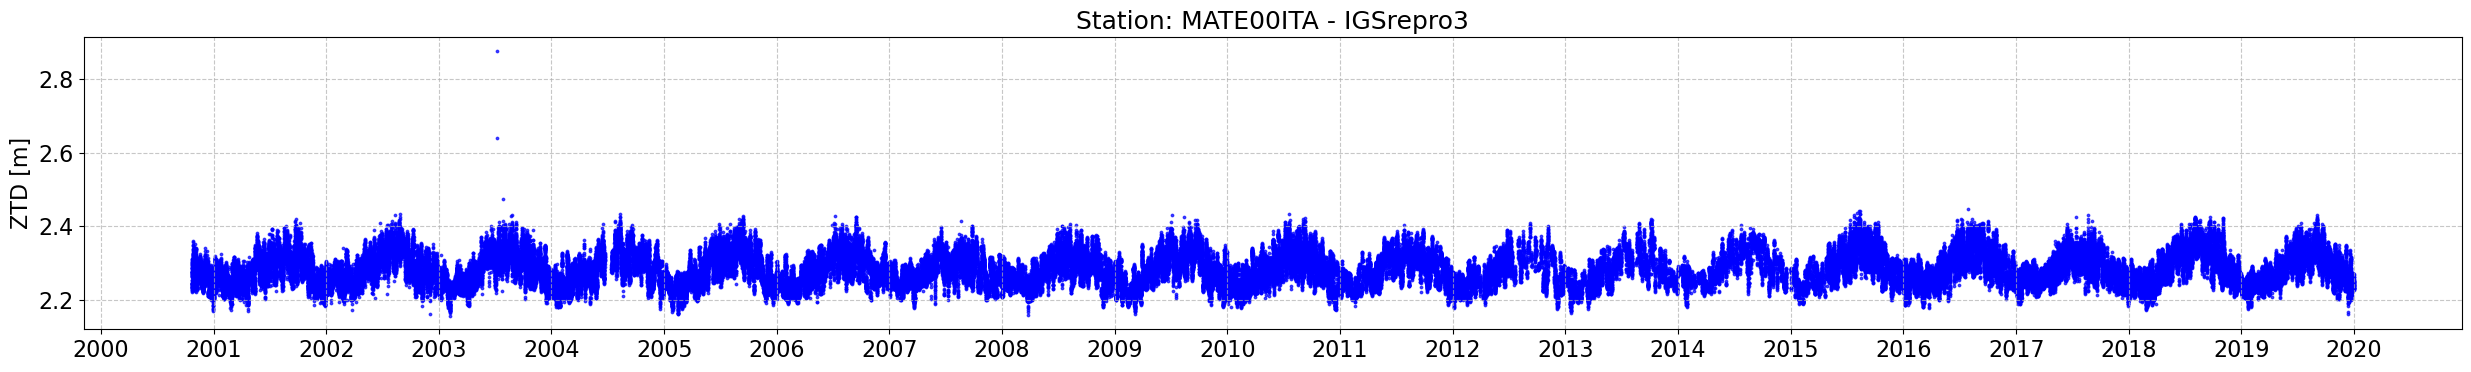

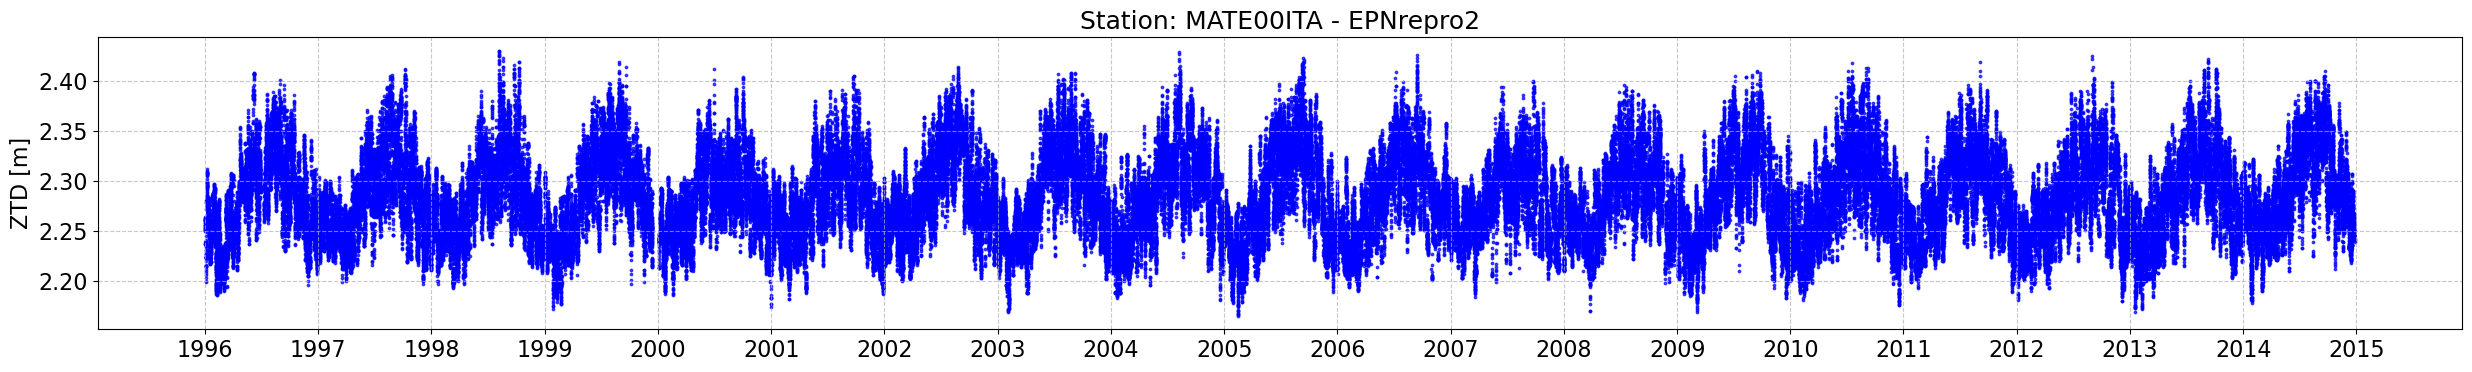

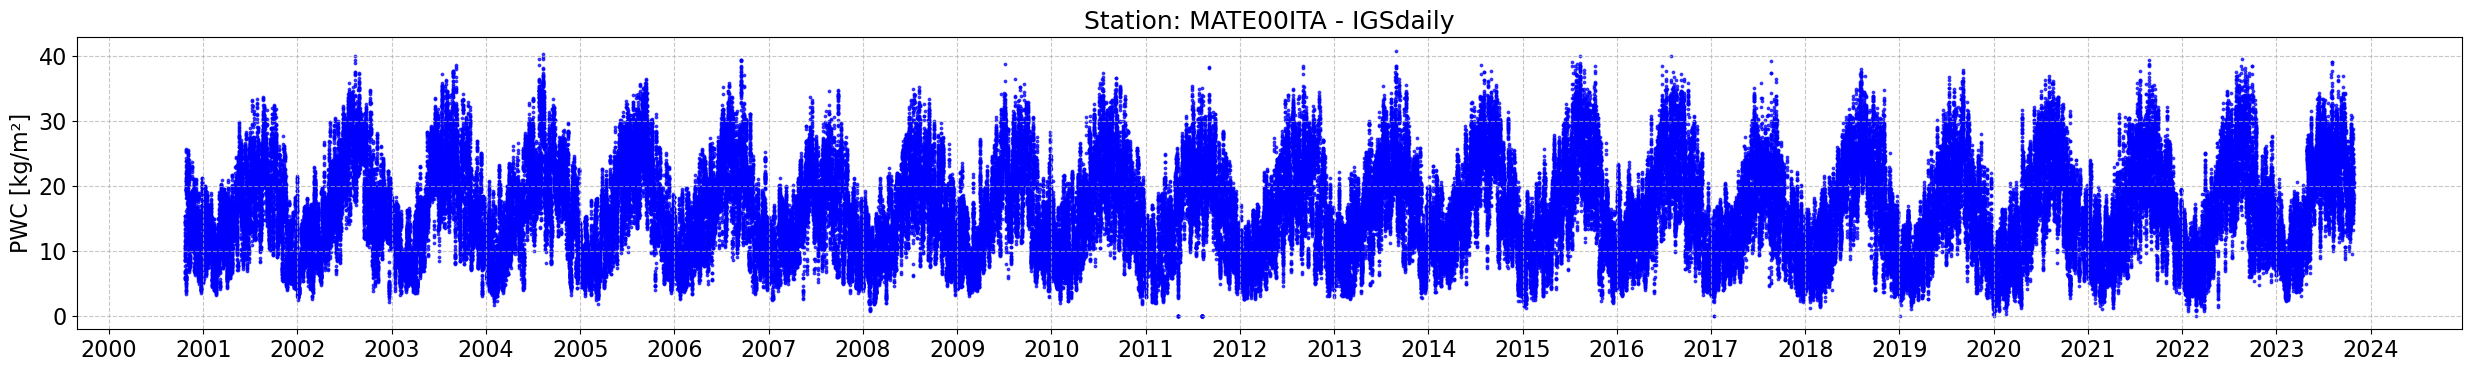

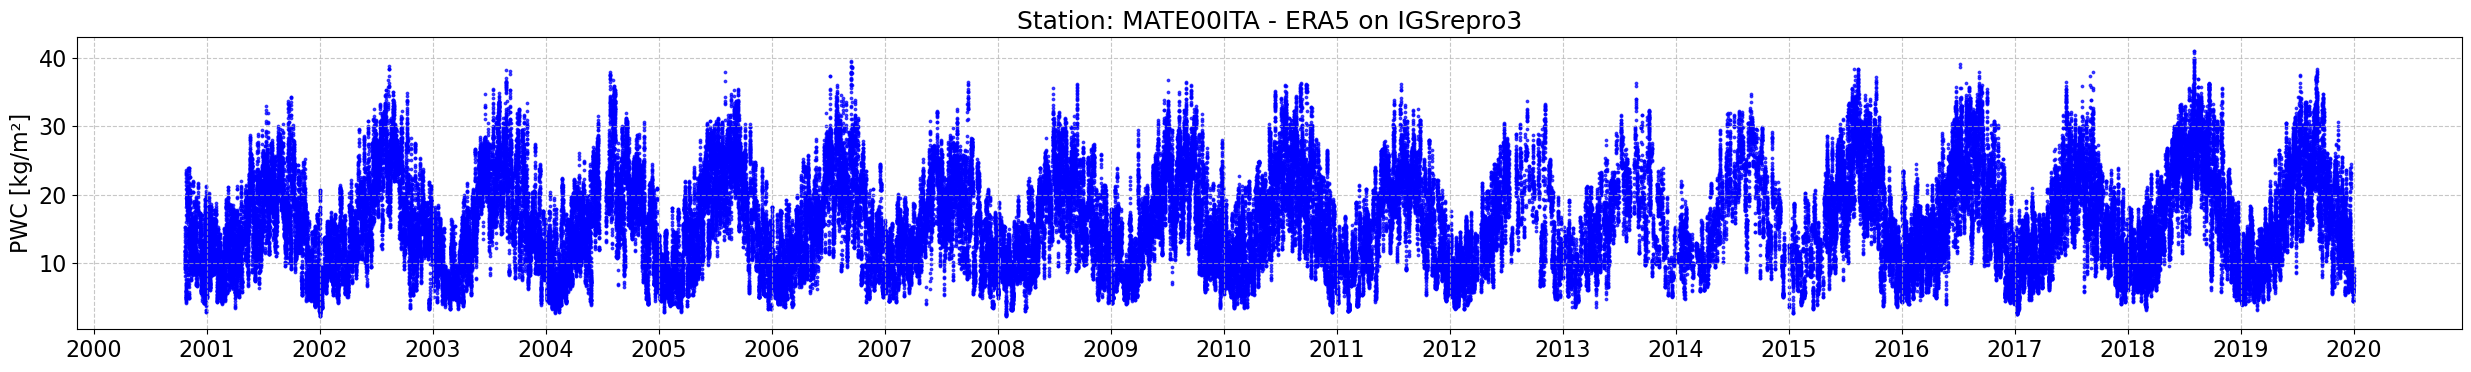

In [19]:
vf.plot_time_series(df_ZTD_igs_repro3, "MATE00ITA", "zenith_total_delay", "IGSrepro3")
vf.plot_time_series(df_ZTD_epn_repro2, "MATE00ITA", "zenith_total_delay", "EPNrepro2")
vf.plot_time_series(df_PWC_igs_daily, "MATE00ITA", "precipitable_water_column", "IGSdaily")
vf.plot_time_series(df_PWC_era5_igs_repro3, "MATE00ITA", "precipitable_water_column_era5", "IGSrepro3")

----

# Metadata from Sitelogs IGS files

### Equipment Changes for IGS Stations

Equipment changes for the IGS stations are available in the form of site logs at the following link:  
[https://files.igs.org/pub/station/log/](https://files.igs.org/pub/station/log/)

In this study, we use a compact form of this information, which includes:
- The date of installation,
- Dates of subsequent changes,
- And the type of change.

Here we only focus on 2 types of changes that are encoded as follows:
- **R**: Receiver  
- **A**: Antenna  

But can also be found data about (see in the link):
- Radome  
- GNSS system  
- Receiver serial number  
- Cutoff angle


In [14]:
try:
    df_equipment = pd.read_csv(
        "/home/hbreton/Documents/Datas/IGS/IGS.eq_change_list.RA.debfin.dates.csv" # Change this path to your file
    )
    df_equipment["Change_Date"] = pd.to_datetime(
        df_equipment["Change_Date"]
    ).dt.strftime("%Y-%m-%d %H:%M:%S")

except FileNotFoundError:
    # Create an empty dataframe with the same structure if file doesn't exist
    df_equipment = pd.DataFrame(
        {"Station": [], "Year": [], "Doy": [], "Change_Date": [], "Type": []}
    )
    print("Equipment file not found, creation of an empty dataframe")

In [10]:
df_equipment #ensure your file got the right format

Station  Year  Doy          Change_Date Type
0       abmf  2008  197  2008-07-15 00:00:00   RA
1       abmf  2008  364  2008-12-29 00:00:00    R
2       abmf  2009  288  2009-10-15 00:00:00   RA
3       abmf  2010  239  2010-08-27 00:00:00    R
4       abmf  2011   83  2011-03-24 00:00:00    R
...      ...   ...  ...                  ...  ...
8374    zwen  1996   32  1996-02-01 00:00:00    R
8375    zwen  1999  251  1999-09-08 00:00:00    R
8376    zwen  2000  251  2000-09-07 00:00:00    R
8377    zwen  2000  265  2000-09-21 00:00:00    A
8378    zwen  2004  266  2004-09-22 00:00:00    A

[8379 rows x 5 columns]

----------

# Compute differences 

Each pair of differences can be computed separately and independently. It requires that you run the corresponding cell in the previous 'Dataframes' section

In [ ]:
custom_base = input(
    "Enter base directory where you saves your files (leave empty to use current folder): "
).strip()
base_dir = Path(custom_base) if custom_base else Path.cwd()
base_dir = base_dir / "Datas" / "EGU2025"  # /home/hbreton/Documents     Adapt to your script

# Compute ΔZTD[IGSDaily - IGSRepro3]

In [ ]:
df_repro3 = df_ZTD_igs_repro3.reset_index()[
    [
        "primary_station_id",
        "report_timestamp",
        "observation_value",
        "uncertainty_value1",
    ]
]
df_daily = df_ZTD_igs_daily.reset_index()[
    [
        "primary_station_id",
        "report_timestamp",
        "observation_value",
        "uncertainty_value1",
    ]
]

df_diff_daily_repro3 = pd.merge(
    df_daily,
    df_repro3,
    on=["primary_station_id", "report_timestamp"],
    how="inner",
    suffixes=("_daily", "_repro3"),
)

del df_daily
del df_repro3

In [ ]:
df_diff_daily_repro3["ZTD_diff"] = (
    df_diff_daily_repro3["observation_value_daily"]
    - df_diff_daily_repro3["observation_value_repro3"]
)
df_diff_daily_repro3 = df_diff_daily_repro3.rename(
    columns={
        "primary_station_id": "Station",
        "observation_value_daily": "ZTD_daily",
        "observation_value_repro3": "ZTD_repro3",
        "report_timestamp": "Date",
        "uncertainty_value1_daily": "sigma_ZTD_daily",
        "uncertainty_value1_repro3": "sigma_ZTD_repro3",
    }
)
df_diff_daily_repro3 = df_diff_daily_repro3.set_index("Station")

In [ ]:
df_diff_daily_repro3.to_parquet(
    f"{base_dir}/full_time_series_data/diff_zenith_total_delay_igs_daily_igs_repro3.parquet"
)

# Compute ΔIWV [IGSDaily - IGSRepro3]

In [ ]:
df_repro3 = df_PWC_igs_repro3.reset_index()[
    [
        "primary_station_id",
        "report_timestamp",
        "observation_value",
        "uncertainty_value5",
    ]
]
df_daily = df_PWC_igs_daily.reset_index()[
    [
        "primary_station_id",
        "report_timestamp",
        "observation_value",
        "uncertainty_value5",
    ]
]

df_diff_daily_repro3 = pd.merge(
    df_daily,
    df_repro3,
    on=["primary_station_id", "report_timestamp"],
    how="inner",
    suffixes=("_daily", "_repro3"),
)
del df_daily
del df_repro3

In [ ]:
df_diff_daily_repro3["PWC_diff"] = (
    df_diff_daily_repro3["observation_value_daily"]
    - df_diff_daily_repro3["observation_value_repro3"]
)
df_diff_daily_repro3 = df_diff_daily_repro3.rename(
    columns={
        "primary_station_id": "Station",
        "observation_value_daily": "PWC_daily",
        "observation_value_repro3": "PWC_repro3",
        "report_timestamp": "Date",
        "uncertainty_value5_daily": "sigma_PWC_daily",
        "uncertainty_value5_repro3": "sigma_PWC_repro3",
    }
)
df_diff_daily_repro3 = df_diff_daily_repro3.set_index("Station")

In [ ]:
df_diff_daily_repro3.to_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_daily_igs_repro3.parquet"
)

# Compute ΔPWC[IGSrepro3 - ERA5]

In [14]:
df_repro3 = df_PWC_igs_repro3.reset_index()[
    ["primary_station_id", "report_timestamp", "observation_value"]
]
df_era5 = df_PWC_era5_igs_repro3.reset_index()[
    ["primary_station_id", "report_timestamp", "observation_value"]
]

df_diff_repro3_era5 = pd.merge(
    df_repro3,
    df_era5,
    on=["primary_station_id", "report_timestamp"],
    how="inner",
    suffixes=("_repro3", "_era5"),
)
del df_repro3
del df_era5

In [15]:
df_diff_repro3_era5["PCW_diff"] = (
    df_diff_repro3_era5["observation_value_repro3"]
    - df_diff_repro3_era5["observation_value_era5"]
)
df_diff_repro3_era5 = df_diff_repro3_era5.rename(
    columns={
        "primary_station_id": "Station",
        "observation_value_repro3": "PCW_repro3",
        "observation_value_era5": "PCW_era5",
        "report_timestamp": "Date",
    }
)
df_diff_repro3_era5 = df_diff_repro3_era5.set_index("Station")

In [17]:
df_diff_repro3_era5.to_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_repro3_era5_{starting_year}_{ending_year}.parquet"
)

# Compute ΔPWC[IGSdaily - ERA5]

In [22]:
df_daily = df_PWC_igs_daily.reset_index()[
    ["primary_station_id", "report_timestamp", "observation_value"]
]
df_era5 = df_PWC_era5_igs_daily.reset_index()[
    ["primary_station_id", "report_timestamp", "observation_value"]
]

df_diff_daily_era5 = pd.merge(
    df_daily,
    df_era5,
    on=["primary_station_id", "report_timestamp"],
    how="inner",
    suffixes=("_daily", "_era5"),
)
del df_daily
del df_era5

In [23]:
df_diff_daily_era5["PCW_diff"] = (
    df_diff_daily_era5["observation_value_daily"]
    - df_diff_daily_era5["observation_value_era5"]
)
df_diff_daily_era5 = df_diff_daily_era5.rename(
    columns={
        "primary_station_id": "Station",
        "observation_value_daily": "PCW_daily",
        "observation_value_era5": "PCW_era5",
        "report_timestamp": "Date",
    }
)
df_diff_daily_era5 = df_diff_daily_era5.set_index("Station")

In [25]:
df_diff_daily_era5.to_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_daily_era5_{starting_year}_{ending_year}.parquet"
)

The same kind of differences can be computed for the other datasets (eg included EPNrepro2), but we will not do it here.

----

# Visualize the intercomparison of the different datasets

### Dataframes

In [29]:
custom_base = input(
    "Enter base directory where you saves your files (leave empty to use current folder): "
).strip()
base_dir = Path(custom_base) if custom_base else Path.cwd()
base_dir = base_dir / "Datas" / "EGU2025"  # /home/hbreton/Documents     Adapt to your script

We don't take into account the EPNrepro2 dataset in this analysis, but it can be done in the same way as for the IGS datasets.

In [30]:
df_diff_ztd_daily_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/diff_zenith_total_delay_igs_daily_igs_repro3.parquet"
)
df_diff_pwc_daily_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_daily_igs_repro3.parquet"
)
df_diff_pwc_repro3_era5 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_repro3_era5_2000_2019.parquet"
)
df_diff_pwc_daily_era5 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/diff_total_column_water_vapour_igs_daily_era5_2000_2023.parquet"
)

### Get rid of the station with less than 3 years of data

In [32]:
dfs = {
    "ΔZTD[IGSdaily-IGSrepro3]": df_diff_ztd_daily_repro3,
    "ΔPWC[IGSdaily-ERA5]": df_diff_pwc_daily_era5,
    "ΔPWC[IGSrepro3-ERA5]": df_diff_pwc_repro3_era5,
    "ΔPWC[IGSdaily-IGSrepro3]": df_diff_pwc_daily_repro3,
}

for i, (name, df) in enumerate(dfs.items()):
    counts = df.groupby("Station").size()
    counts_sorted = counts.sort_values(ascending=True)
    low_data_stations = counts_sorted[counts_sorted < 26280].index.tolist()

    print(f"Stations with less than 26280 days (3 years): {len(low_data_stations)}")
    if len(low_data_stations) > 0:
        print(f"Example stations with less then 3 years of data: {low_data_stations[:5]}")

    if "low_data_stations_dict" not in globals():
        globals()["low_data_stations_dict"] = {}

    globals()["low_data_stations_dict"][name] = low_data_stations

    if len(low_data_stations) > 0:
        df = dfs[name]
        df_filtered = df[~df.index.get_level_values("Station").isin(low_data_stations)]
        filtered_df_name = f"df_diff_{name.replace('-', '_')}_filtered"
        globals()[filtered_df_name] = df_filtered
        removed_rows = len(df) - len(df_filtered)
        print(
            f"\nFiltered out {removed_rows} rows ({removed_rows/len(df)*100:.2f}%) from {len(low_data_stations)} stations"
        )
        print(
            f"Original dataframe: {len(df)} rows, Filtered dataframe: {len(df_filtered)} rows"
        )

print("Saving filtered dataframes to parquet files...")
pwc_daily_era5_filtered = globals()["df_diff_ΔPWC[IGSdaily_ERA5]_filtered"]
pwc_repro3_era5_filtered = globals()["df_diff_ΔPWC[IGSrepro3_ERA5]_filtered"]
pwc_daily_repro3_filtered = globals()["df_diff_ΔPWC[IGSdaily_IGSrepro3]_filtered"]
ztd_daily_repro3_filtered = globals()["df_diff_ΔZTD[IGSdaily_IGSrepro3]_filtered"]

pwc_daily_era5_filtered.to_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_daily_era5_2000_2023.parquet"
)
pwc_repro3_era5_filtered.to_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_repro3_era5_2000_2019.parquet"
)
pwc_daily_repro3_filtered.to_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_daily_igs_repro3.parquet"
)
ztd_daily_repro3_filtered.to_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_zenith_total_delay_igs_daily_igs_repro3.parquet"
)

print("All filtered dataframes saved successfully.")

Stations with less than 26280 days (3 years): 68
Example stations with less then 3 years of data: ['MTBG00AUT', 'BOAV00BRA', 'WTZ300DEU', 'KWJ100MHL', 'SUNM00AUS']

Filtered out 934346 rows (2.49%) from 68 stations
Original dataframe: 37479676 rows, Filtered dataframe: 36545330 rows
Stations with less than 26280 days (3 years): 113
Example stations with less then 3 years of data: ['FAIV00USA', 'TABV00USA', 'KWJ100MHL', 'SUNM00AUS', 'OBET00DEU']

Filtered out 1489728 rows (2.28%) from 113 stations
Original dataframe: 65283864 rows, Filtered dataframe: 63794136 rows
Stations with less than 26280 days (3 years): 17
Example stations with less then 3 years of data: ['MTBG00AUT', 'FREE00BHS', 'KWJ100MHL', 'TGCV00CPV', 'MDVO00RUS']

Filtered out 309532 rows (0.68%) from 17 stations
Original dataframe: 45666183 rows, Filtered dataframe: 45356651 rows
Stations with less than 26280 days (3 years): 68
Example stations with less then 3 years of data: ['MTBG00AUT', 'BOAV00BRA', 'WTZ300DEU', 'KWJ100

### Dataframes (only stations with more than 3 years of data)

We did not compute any differences for the EPNrepro2 dataset. Therefore, no filtered DataFrames are available for this case.

If you choose not to process differences for a given dataset, please define it as an empty DataFrame with two columns, depending on the variable being compared:

    For Zenith Total Delay (ZTD):

In [33]:
pd.DataFrame({'Station': [], 'ZTD_diff': []}).set_index('Station')

Empty DataFrame
Columns: [ZTD_diff]
Index: []

    For Precipitable Water Content (PWC):

In [32]:
pd.DataFrame({'Station': [], 'PWC_diff': []}).set_index('Station')

Empty DataFrame
Columns: [PWC_diff]
Index: []

In [9]:
df_diff_ztd_daily_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_zenith_total_delay_igs_daily_igs_repro3.parquet"
)
df_diff_ztd_daily_repro2 = pd.DataFrame({'Station': [], 'ZTD_diff': []}).set_index('Station')
df_diff_ztd_repro3_repro2 = pd.DataFrame({'Station': [], 'ZTD_diff': []}).set_index('Station')



df_diff_pwc_daily_repro3 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_daily_igs_repro3.parquet"
)
df_diff_pwc_daily_repro2 = pd.DataFrame({'Station': [], 'PWC_diff': []}).set_index('Station')
df_diff_pwc_repro3_repro2 = pd.DataFrame({'Station': [], 'PWC_diff': []}).set_index('Station')



df_diff_pwc_repro3_era5 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_repro3_era5_2000_2019.parquet"
)
df_diff_pwc_daily_era5 = pd.read_parquet(
    f"{base_dir}/full_time_series_data/Over_3_years_diff_total_column_water_vapour_igs_daily_era5_2000_2023.parquet"
)
df_diff_pwc_repro2_era5 = pd.DataFrame({'Station': [], 'PWC_diff': []}).set_index('Station')

In [10]:
dataframes_dict = {
    "ΔZTD[IGSdaily-IGSrepro3]": df_diff_ztd_daily_repro3,
    "ΔZTD[IGSdaily-EPNrepro2]": df_diff_ztd_daily_repro2,
    "ΔZTD[IGSrepro3-EPNrepro2]": df_diff_ztd_repro3_repro2,

    "ΔPWC[IGSdaily-IGSrepro3]": df_diff_pwc_daily_repro3,
    "ΔPWC[IGSdaily-EPNrepro2]": df_diff_pwc_daily_repro2,
    "ΔPWC[IGSrepro3-EPNrepro2]": df_diff_pwc_repro3_repro2,

    "ΔPWC[IGSdaily-ERA5]": df_diff_pwc_daily_era5,
    "ΔPWC[IGSrepro3-ERA5]": df_diff_pwc_repro3_era5,
    "ΔPWC[EPNrepro2-ERA5]": df_diff_pwc_repro2_era5,
} 

# Name of the keys are important and must remain the same as shown 
# Adapt the name of your dataframes if you want to use intercomparison with EPNrepro2

diff_columns = {
    "ΔZTD[IGSdaily-IGSrepro3]": "ZTD_diff",
    "ΔZTD[IGSdaily-EPNrepro2]": "ZTD_diff",
    "ΔZTD[IGSrepro3-EPNrepro2]": "ZTD_diff",

    "ΔPWC[IGSdaily-IGSrepro3]": "PWC_diff",
    "ΔPWC[IGSdaily-EPNrepro2]": "PWC_diff",
    "ΔPWC[IGSrepro3-EPNrepro2]": "PWC_diff",

    "ΔPWC[IGSdaily-ERA5]": "PWC_diff",
    "ΔPWC[IGSrepro3-ERA5]": "PWC_diff",
    "ΔPWC[EPNrepro2-ERA5]": "PWC_diff",
}

### General stats

In [11]:
station_stats_dict = {}

for label, df in dataframes_dict.items():
    diff_column = diff_columns[label]

    station_stats = df.groupby("Station")[diff_column].agg(["median"]).reset_index()
    station_stats["IQR"] = (
        df.groupby("Station")[diff_column]
        .apply(lambda x: x.quantile(0.75)-x.quantile(0.25))
        .values
    )
    station_stats["mean"] = df.groupby("Station")[diff_column].mean().values
    station_stats["abs_median"] = station_stats["median"].abs()
    station_stats["abs_mean"] = station_stats["mean"].abs()
    station_stats["std"] = df.groupby("Station")[diff_column].std().values
    station_stats["IQR/1.35"] = station_stats["IQR"] / 1.35
    station_stats_dict[label] = station_stats

station_stats_PWC_REPRO3_ERA5 = station_stats_dict["ΔPWC[IGSrepro3-ERA5]"]
station_stats_PWC_DAILY_ERA5 = station_stats_dict["ΔPWC[IGSdaily-ERA5]"]
station_stats_ZTD_DAILY_REPRO3 = station_stats_dict["ΔZTD[IGSdaily-IGSrepro3]"]
station_stats_PWC_DAILY_REPRO3 = station_stats_dict["ΔPWC[IGSdaily-IGSrepro3]"]

In [12]:
station_stats_ZTD_DAILY_REPRO3_mm = station_stats_ZTD_DAILY_REPRO3.copy()
numeric_columns = ["median", "IQR", "mean", "abs_median", "abs_mean", "std", "IQR/1.35"]
station_stats_ZTD_DAILY_REPRO3_mm[numeric_columns] = (
    station_stats_ZTD_DAILY_REPRO3[numeric_columns] * 1000
)

### ΔZTD[IGSdaily - IGSrepro3] 

<Figure size 1000x600 with 0 Axes>

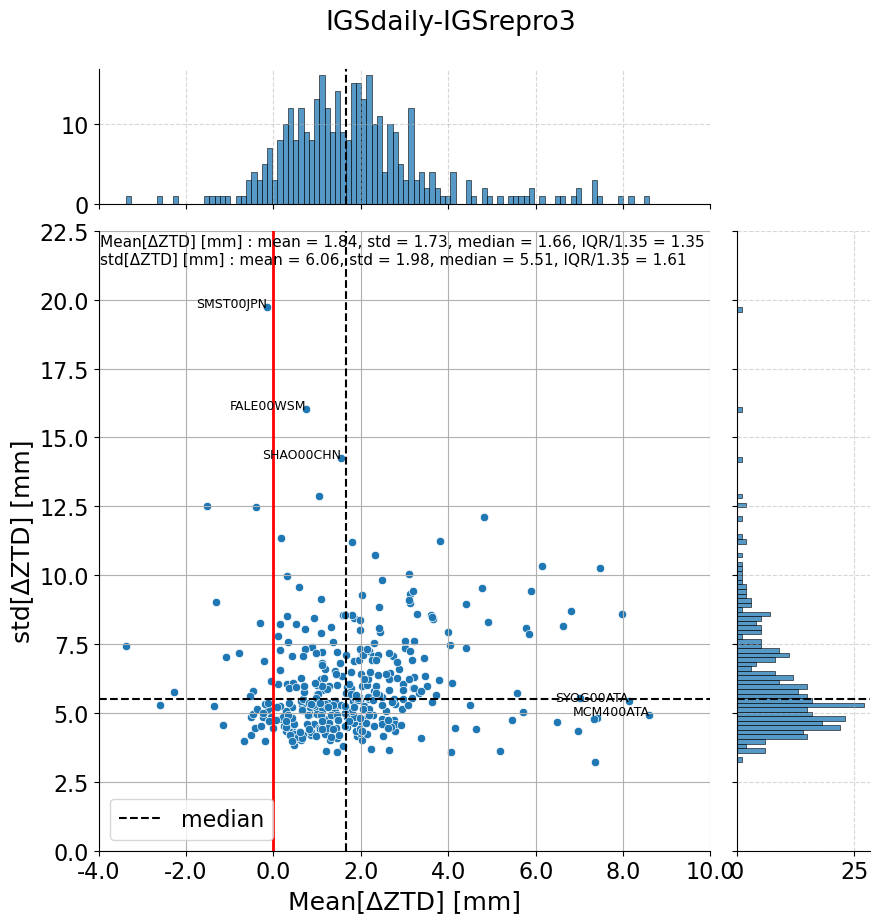

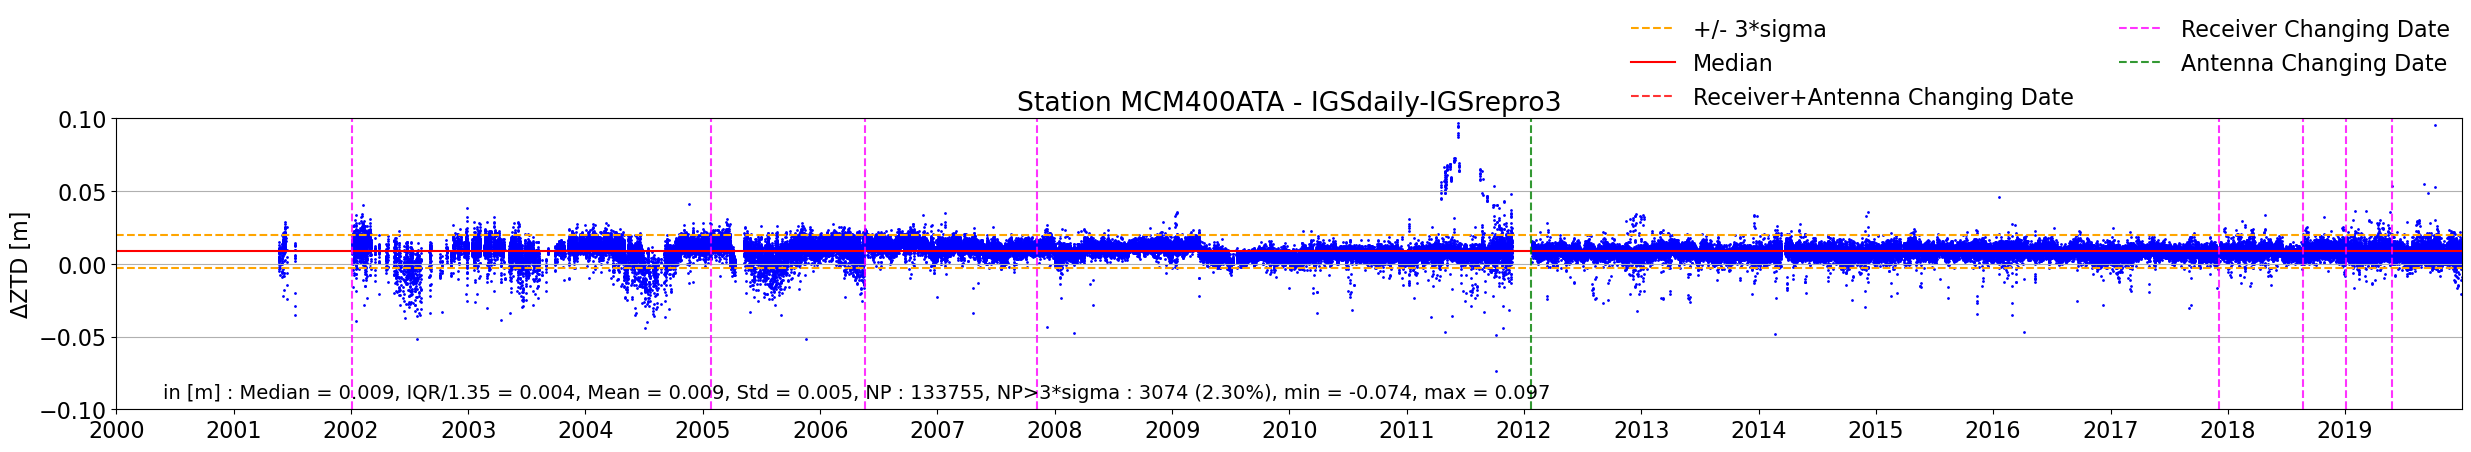

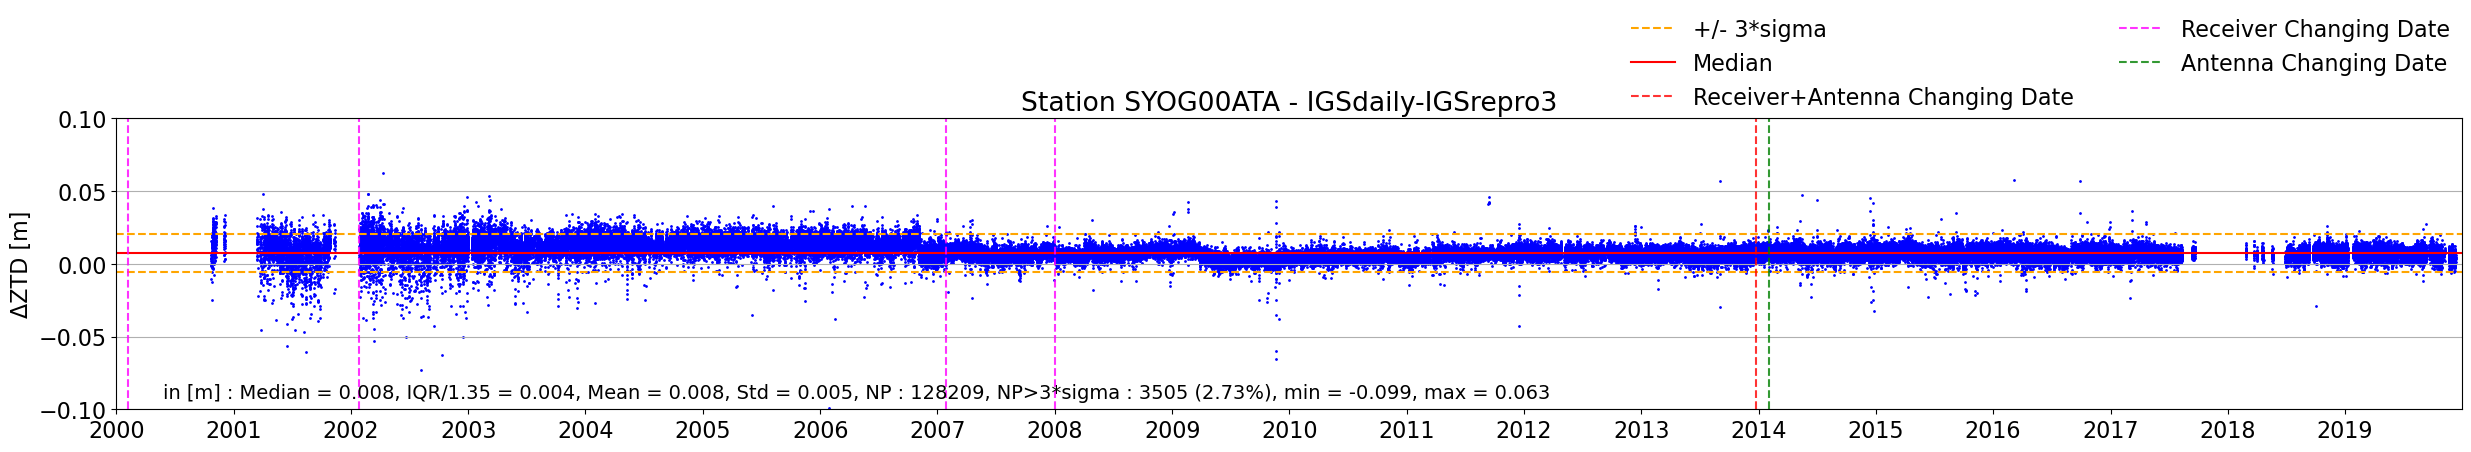

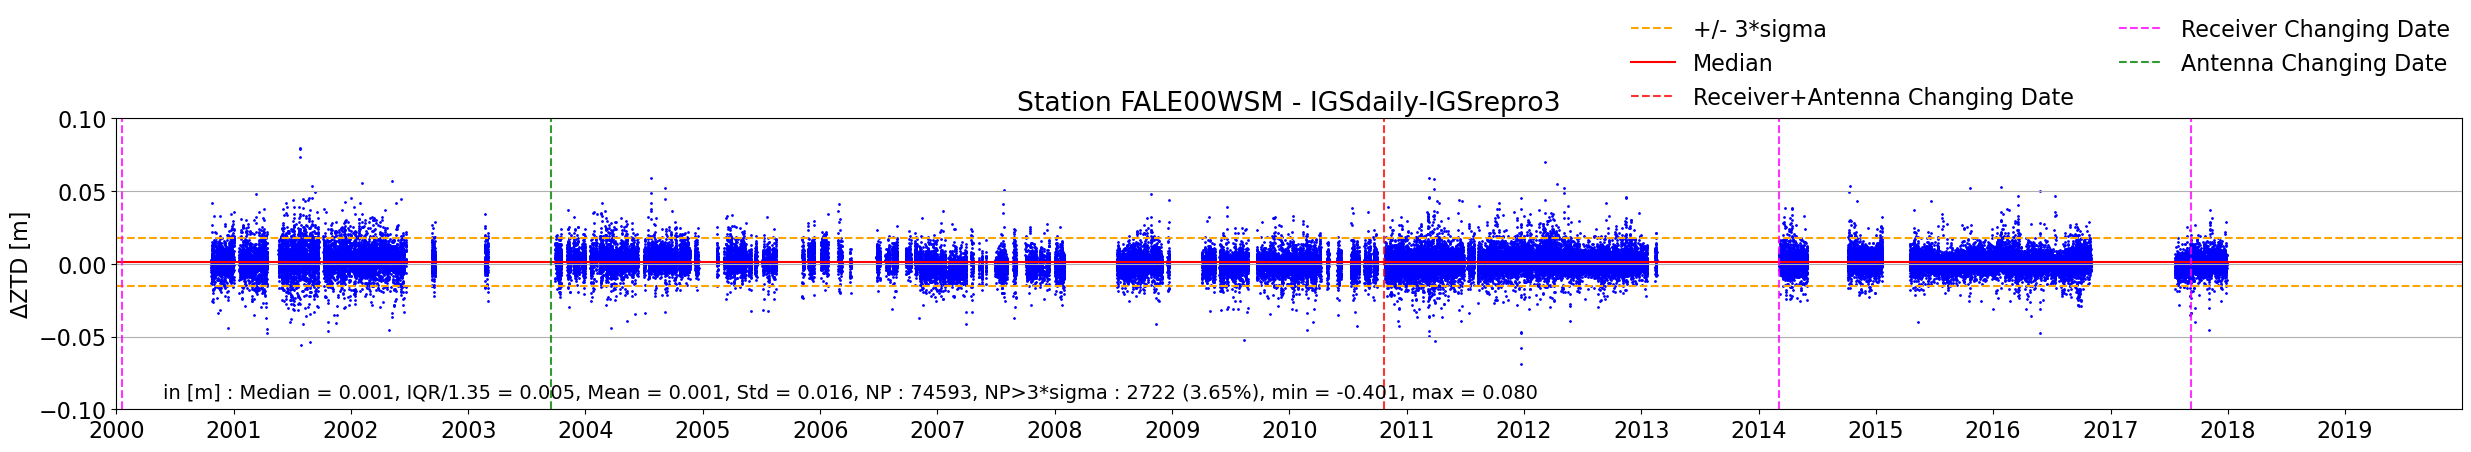

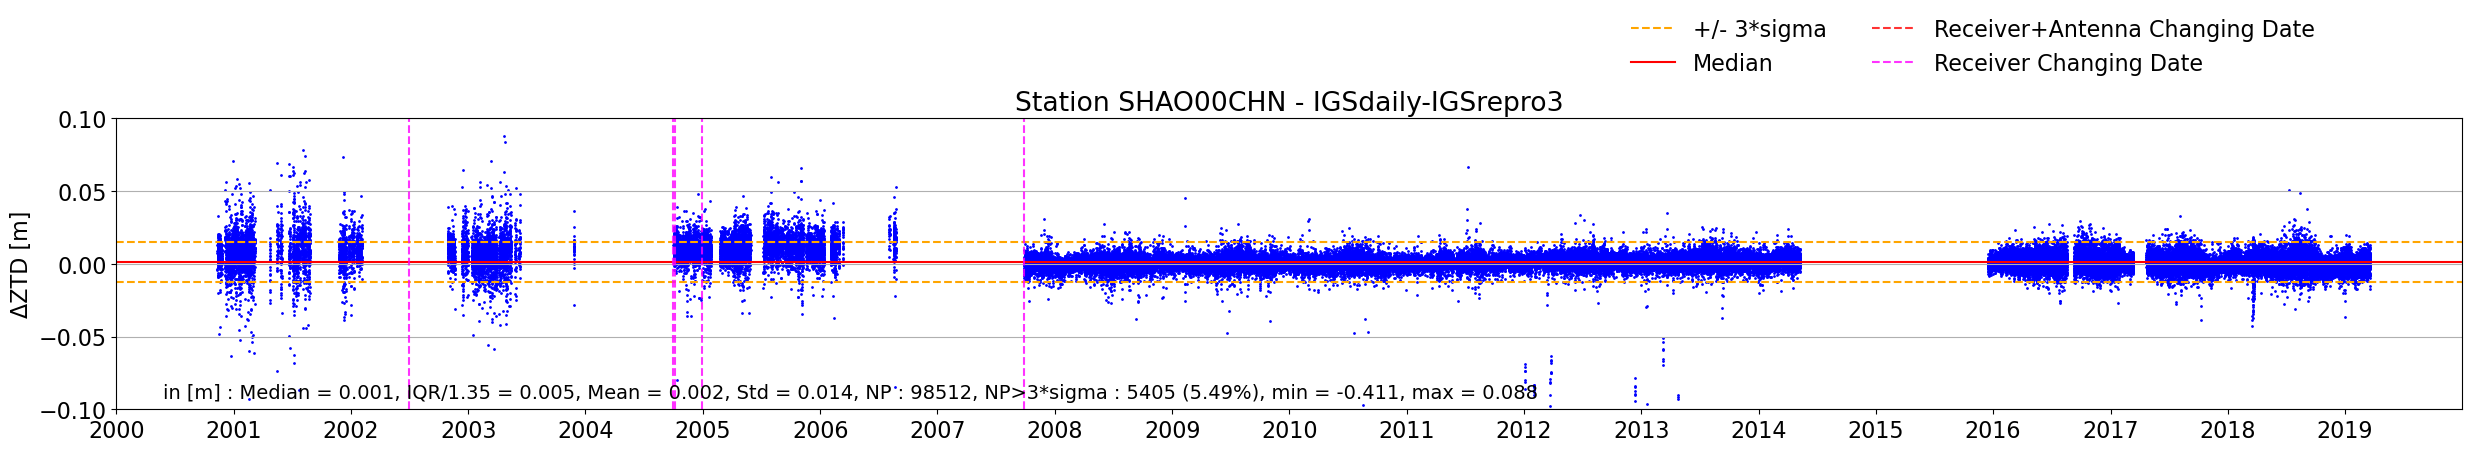

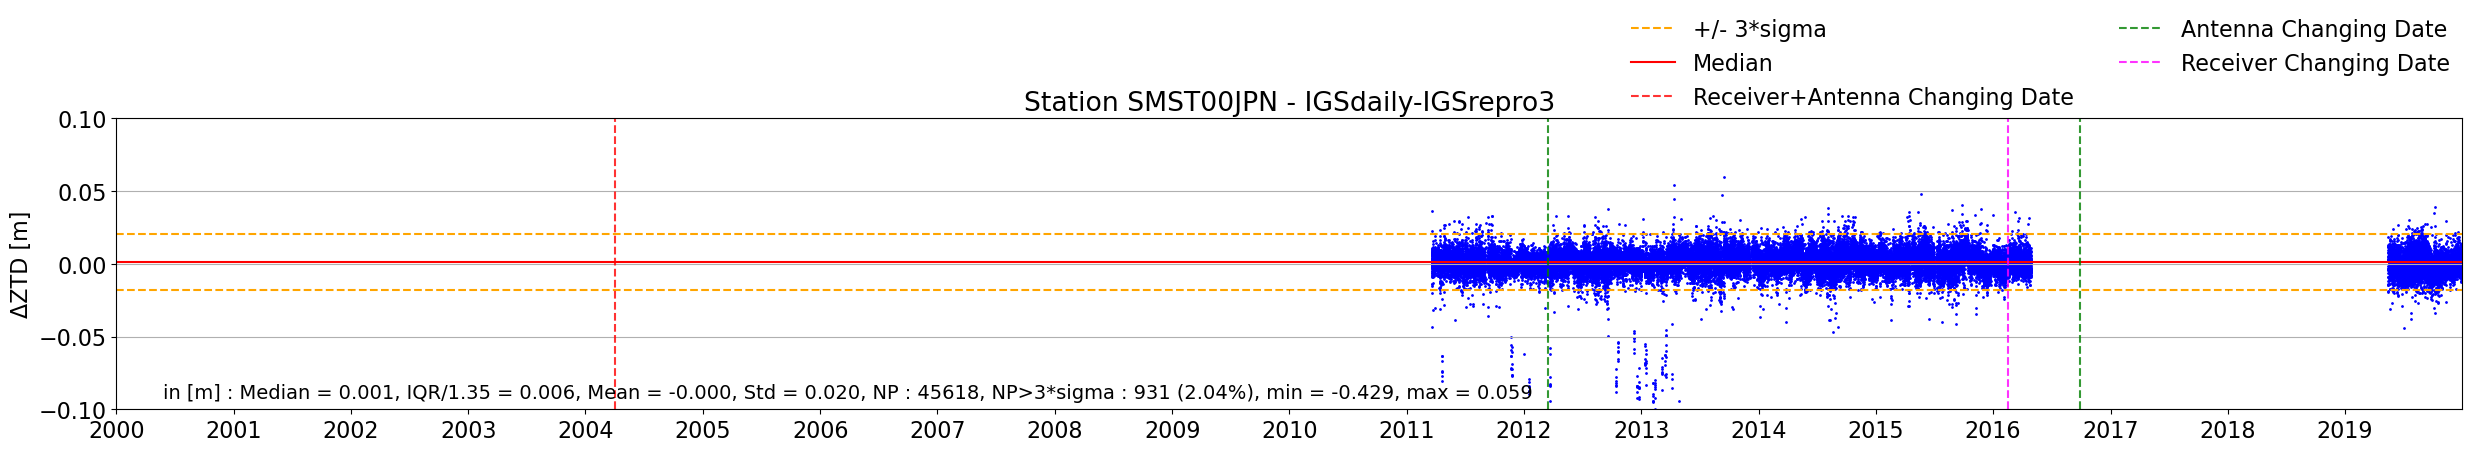

In [20]:
vf.plot_scatter_joint_stats(
    station_stats_ZTD_DAILY_REPRO3_mm,
    df_equipment,
    dataframes_dict,
    datatype="ZTD",
    x_col="mean",
    y_col="std",
    title="IGSdaily-IGSrepro3",
    xlabel="Mean[ΔZTD] [mm]",
    ylabel="std[ΔZTD] [mm]",
    xlim=(pd.to_datetime("2000-01-01"), pd.to_datetime("2019-12-31")),
    ylim=[-0.1, 0.1],
    annotate_worst=False,
    n_worst=5,
    annotate_threshold_worst=True,
    threshold_mean=(-5, 8),
    threshold_std=13,
    show_grid=True,
    show_stats=True,
    save=False,
    save_path=f"{base_dir}",
    dpi=600,
)

### ΔPWC[IGSdaily - IGSrepro3]

<Figure size 1000x600 with 0 Axes>

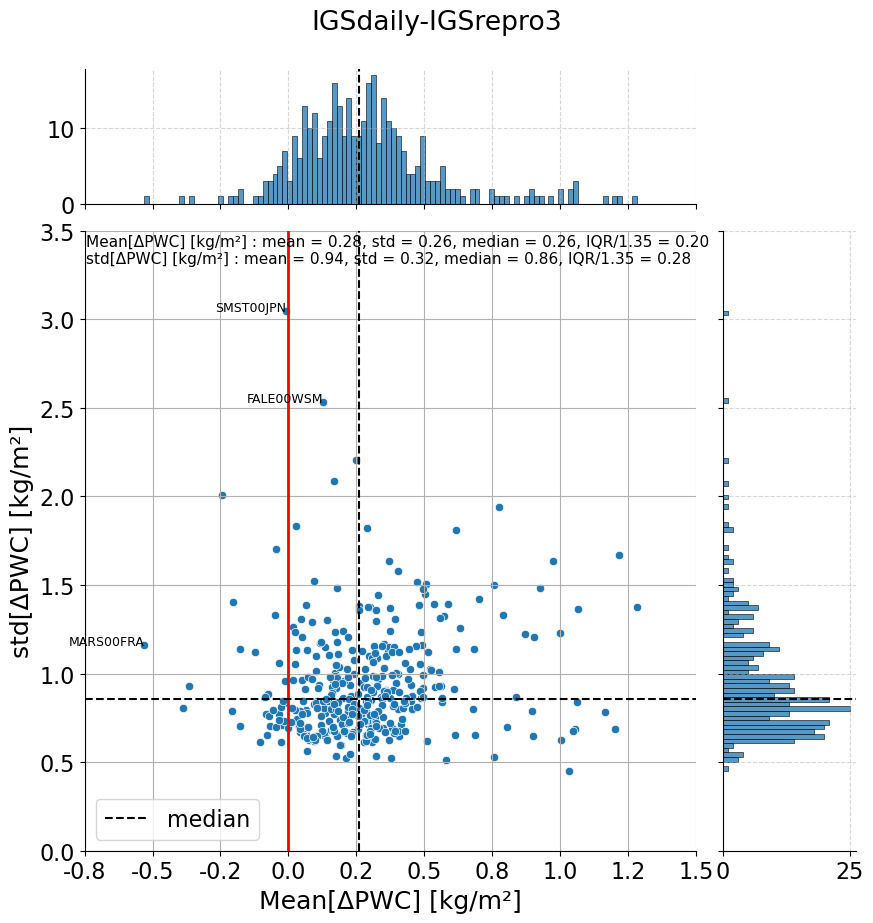

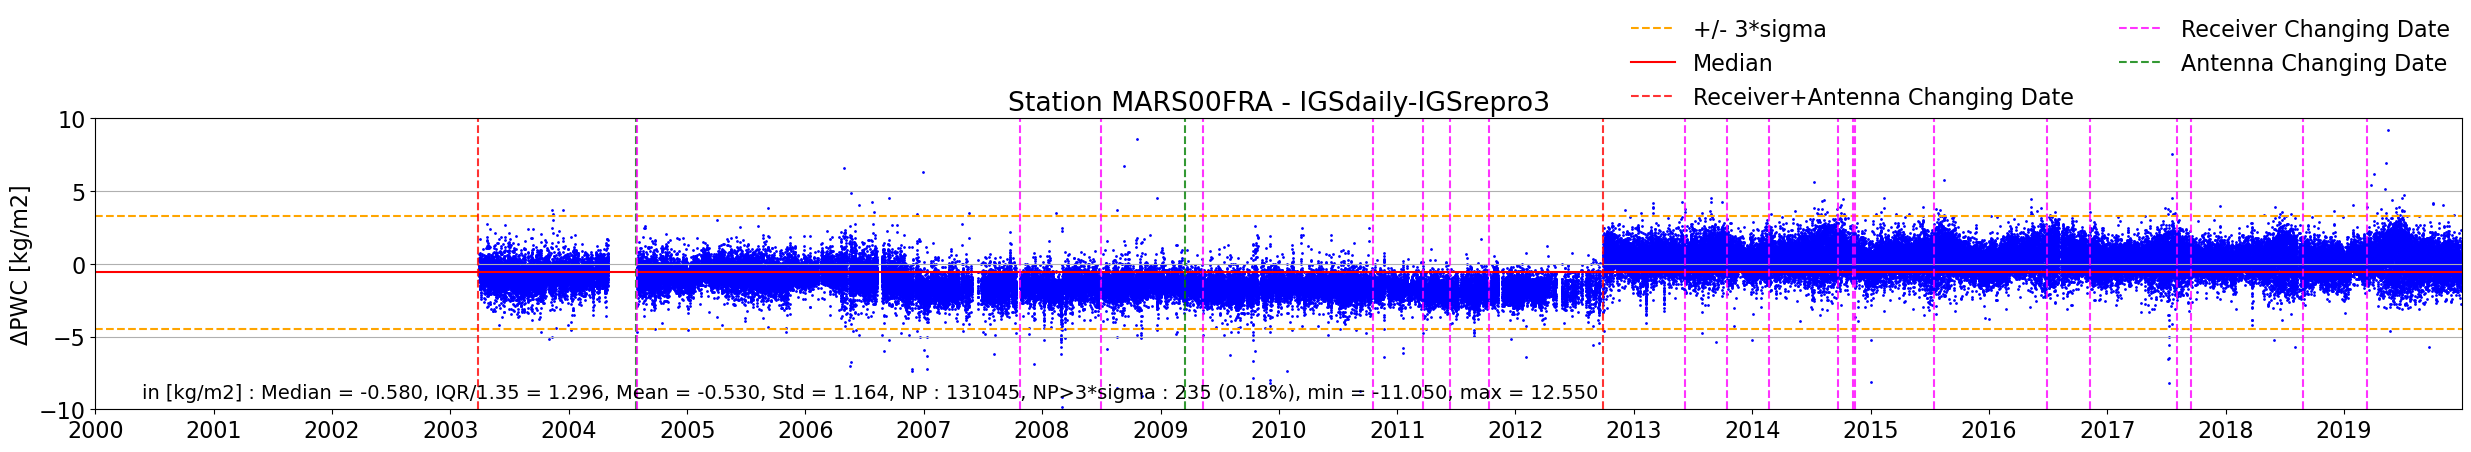

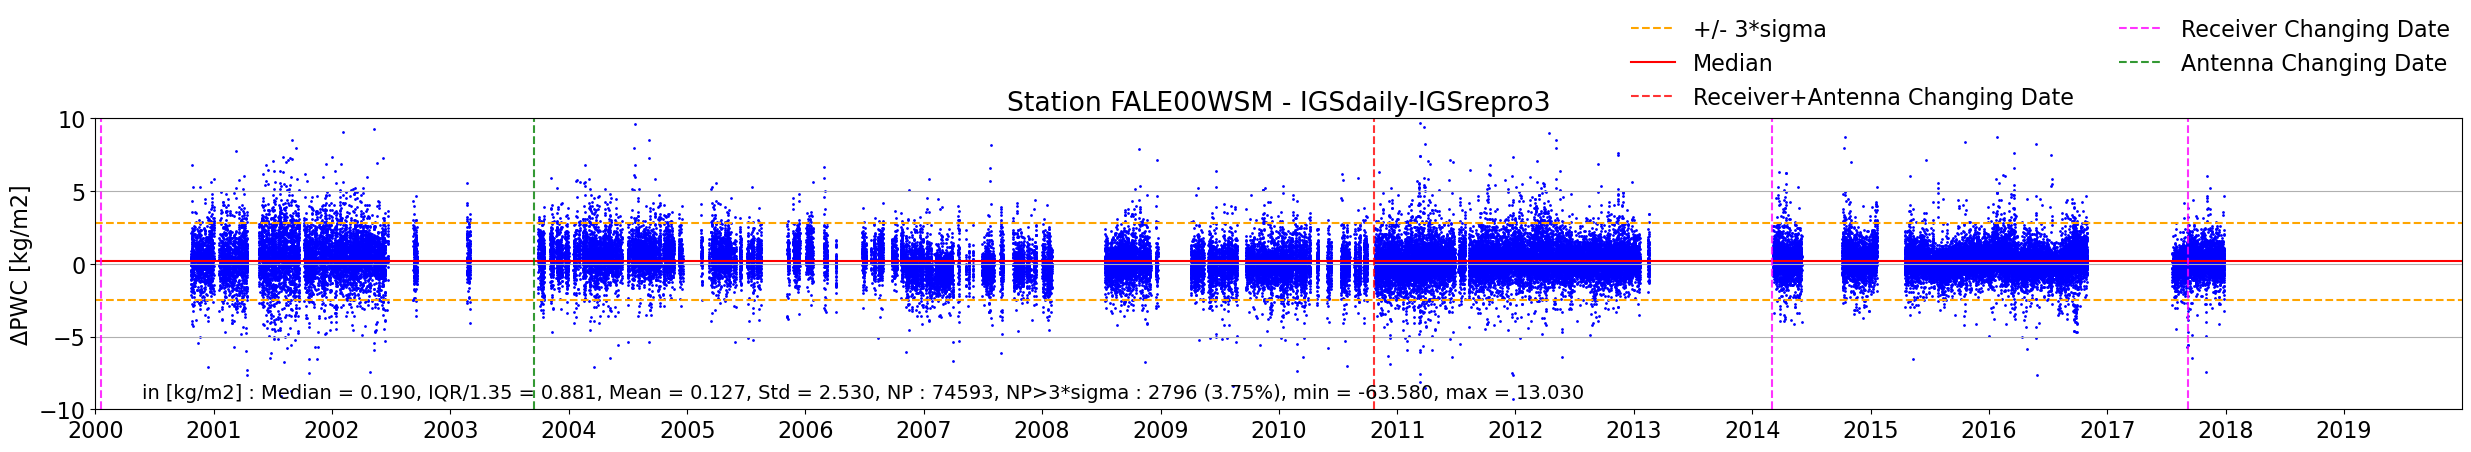

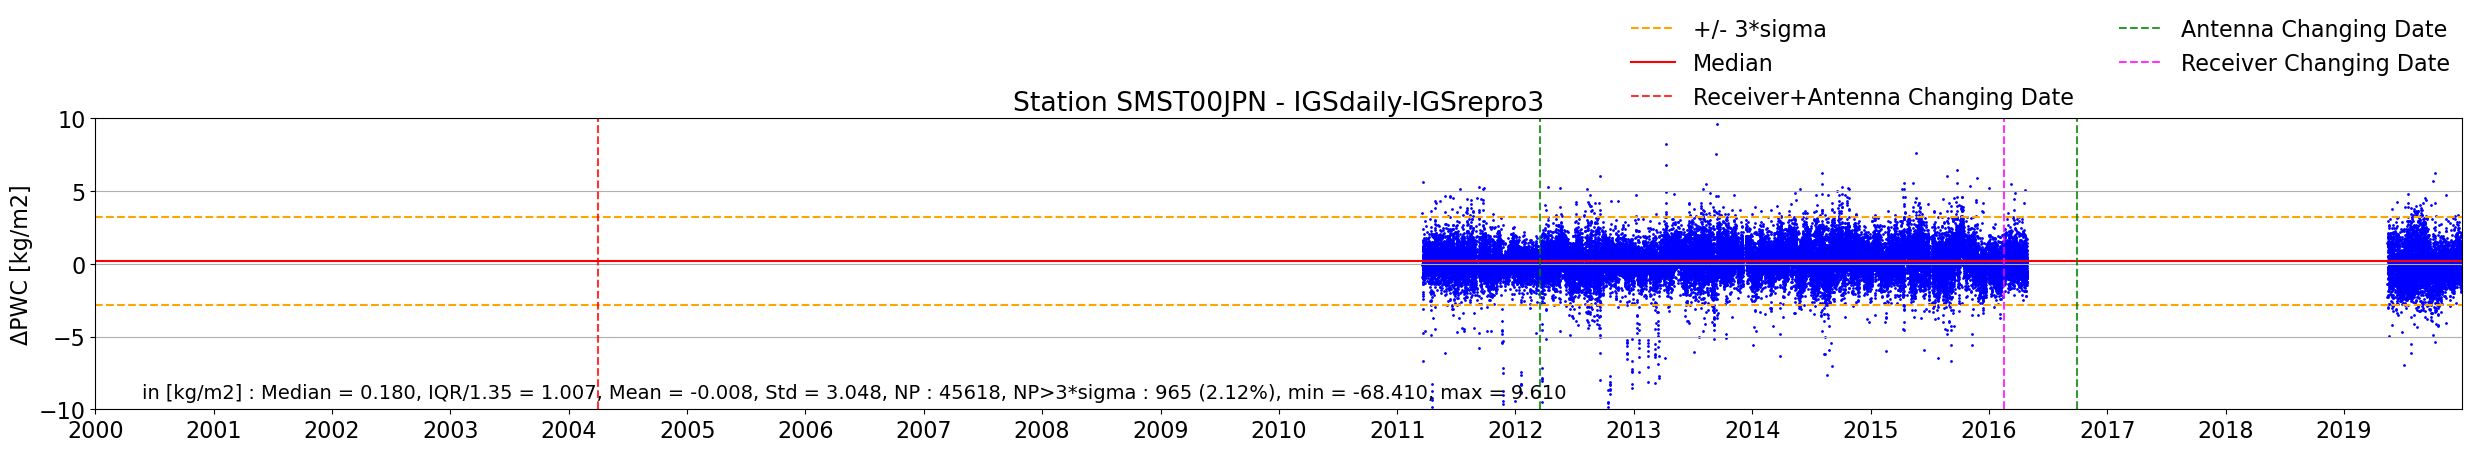

In [21]:
vf.plot_scatter_joint_stats(
    station_stats_PWC_DAILY_REPRO3,
    df_equipment,
    dataframes_dict,
    x_col="mean",
    y_col="std",
    title="IGSdaily-IGSrepro3",
    xlabel="Mean[ΔPWC] [kg/m²]",
    ylabel="std[ΔPWC] [kg/m²]",
    xlim=(pd.to_datetime("2000-01-01"), pd.to_datetime("2019-12-31")),
    ylim=[-10, 10],
    annotate_worst=False,
    n_worst=5,
    annotate_threshold_worst=True,
    threshold_mean=(-0.5, 1.5),
    threshold_std=2.5,
    show_grid=True,
    show_stats=True,
    save=False,
    save_path=f"{base_dir}",
    dpi=600,
)

### ΔPWC[IGSdaily - ERA5]

<Figure size 1000x600 with 0 Axes>

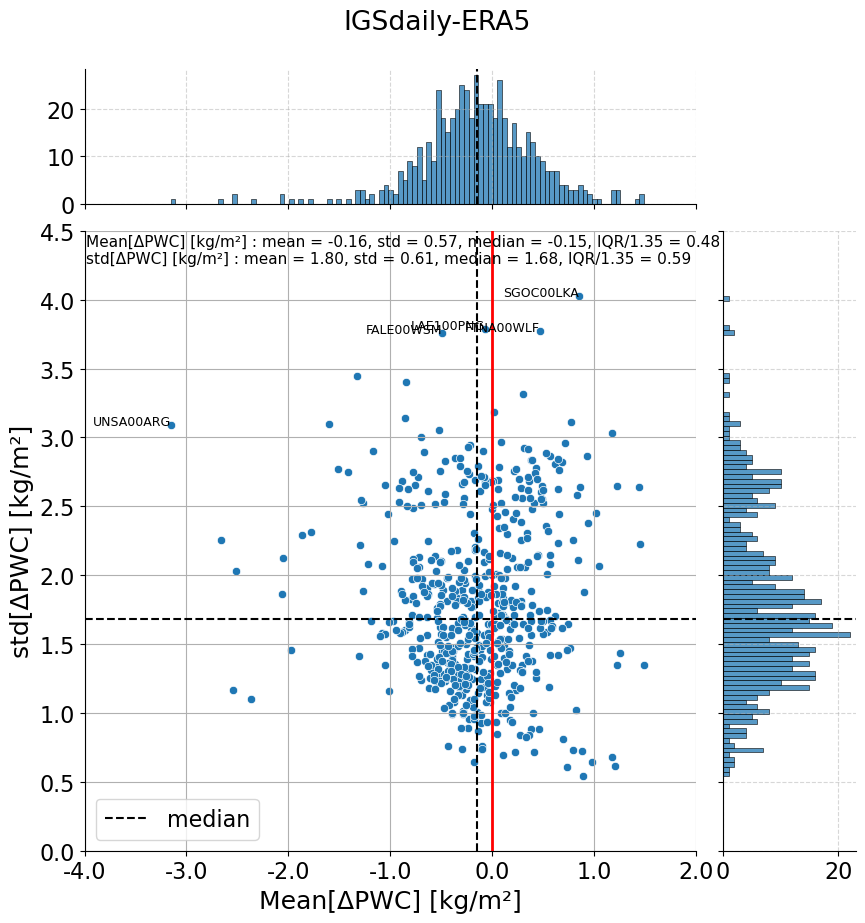

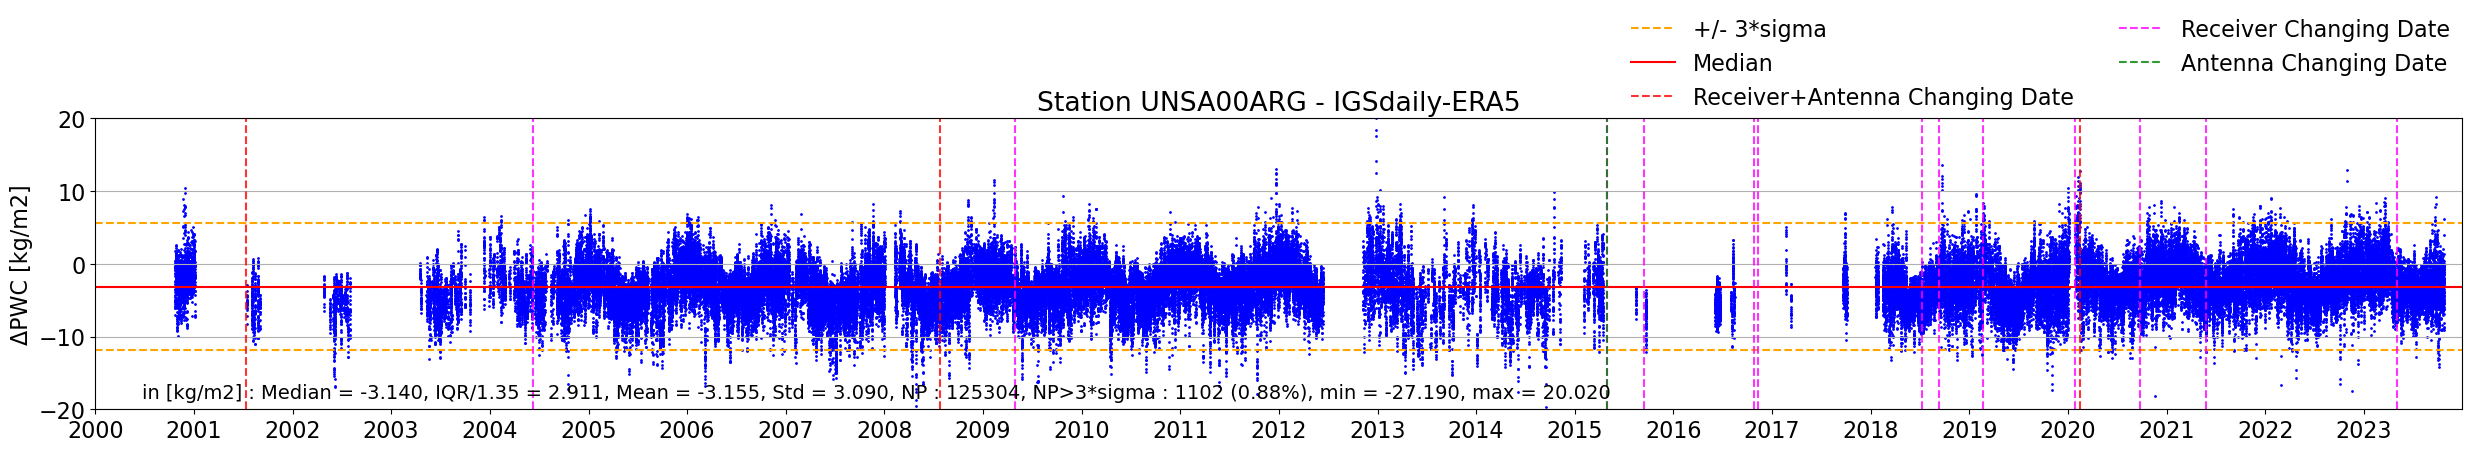

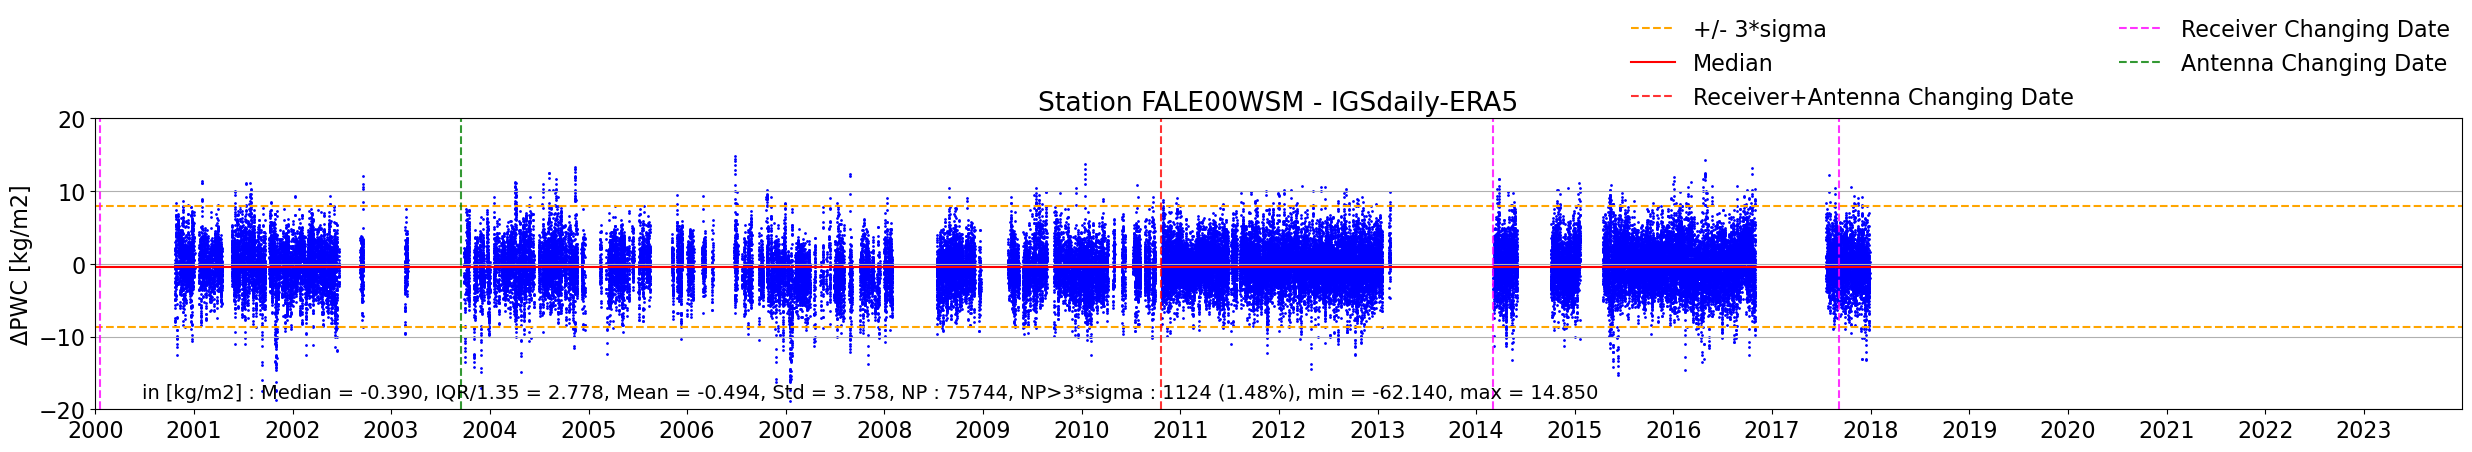

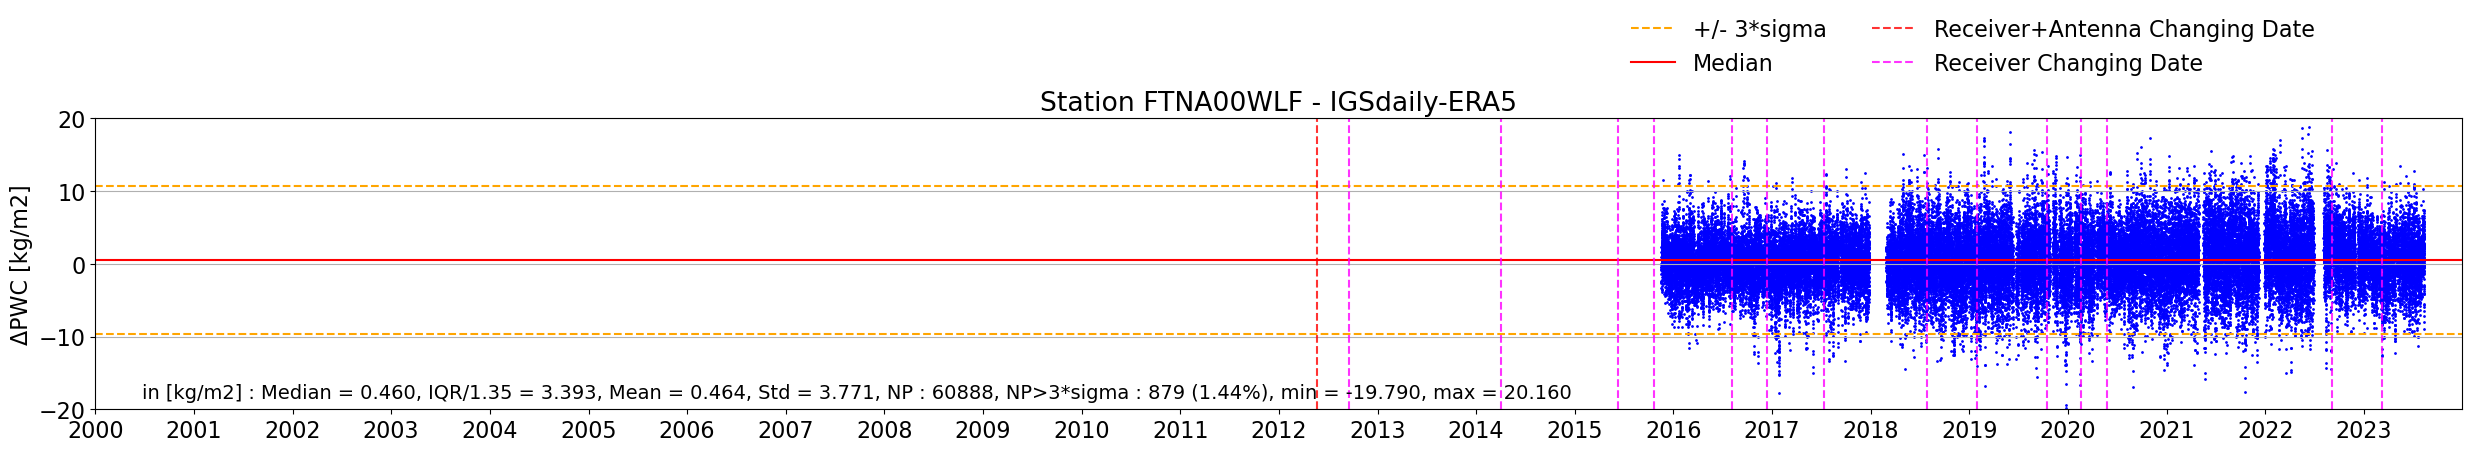

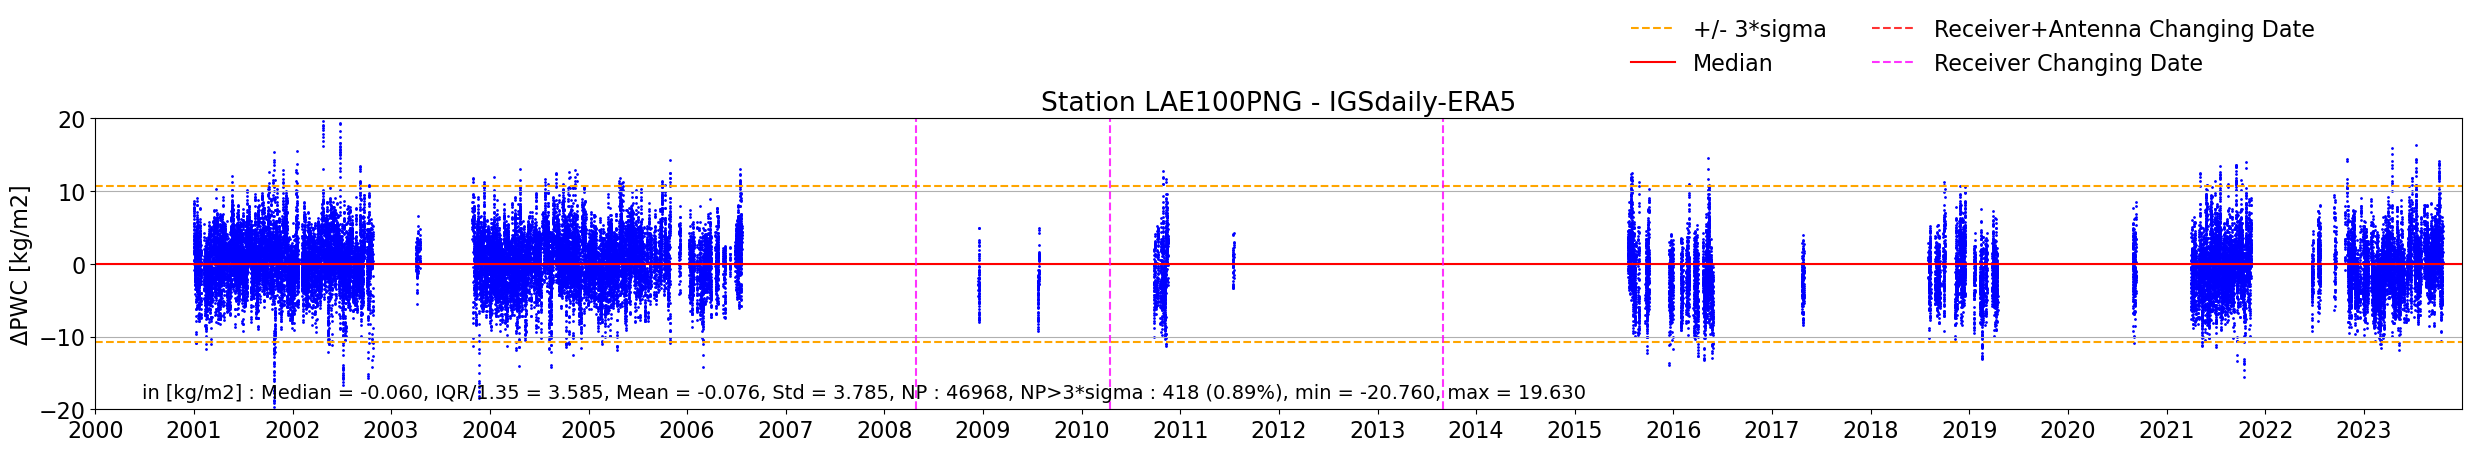

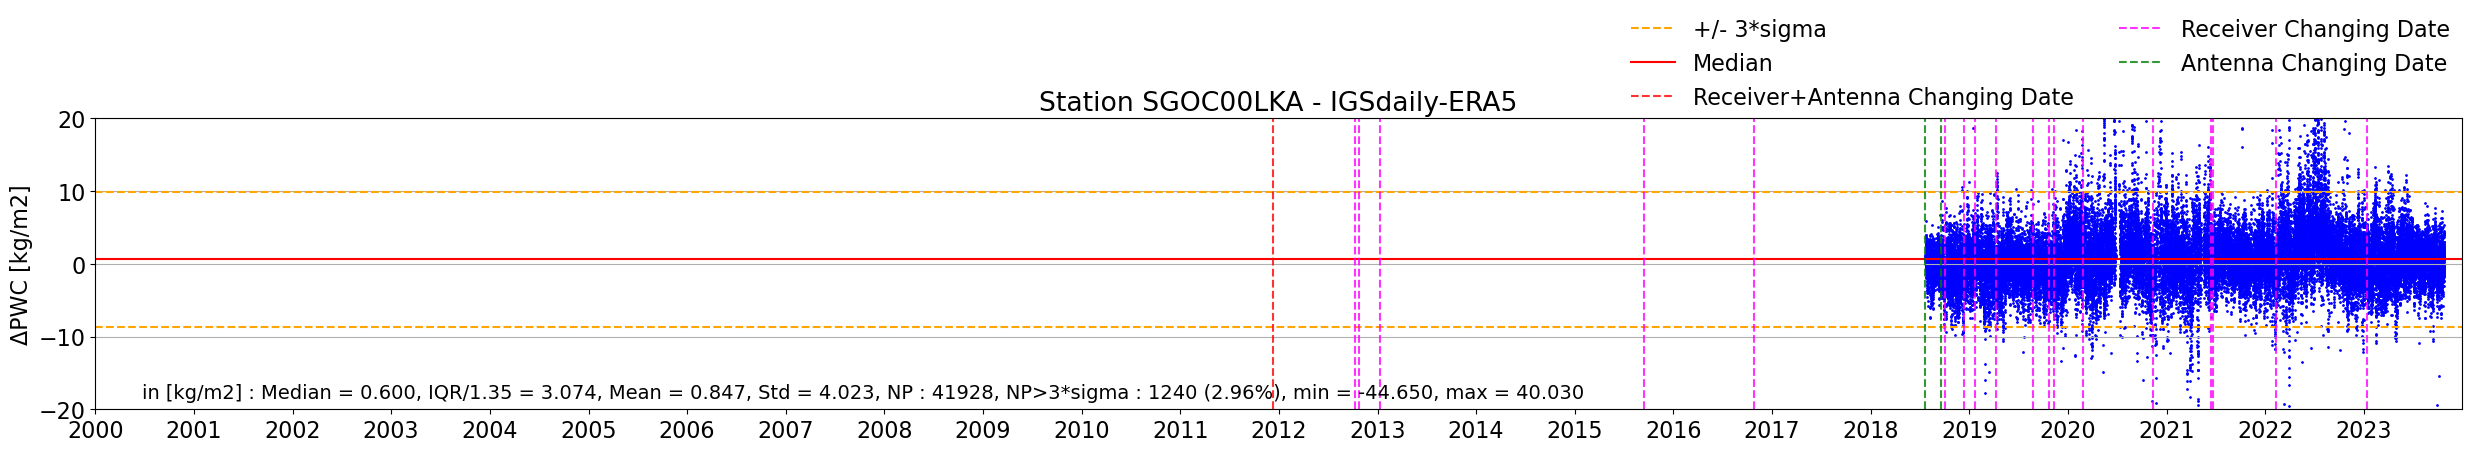

In [22]:
vf.plot_scatter_joint_stats(
    station_stats_PWC_DAILY_ERA5,
    df_equipment,
    dataframes_dict,
    x_col="mean",
    y_col="std",
    title="IGSdaily-ERA5",
    xlabel="Mean[ΔPWC] [kg/m²]",
    ylabel="std[ΔPWC] [kg/m²]",
    xlim=(pd.to_datetime("2000-01-01"), pd.to_datetime("2023-12-31")),
    annotate_worst=False,
    n_worst=5,
    annotate_threshold_worst=True,
    threshold_mean=(-3, 2),
    threshold_std=3.5,
    show_grid=True,
    show_stats=True,
    save=False,
    save_path=f"{base_dir}",
    dpi=600,
)

### ΔPWC[IGSrepro3 - ERA5]

<Figure size 1000x600 with 0 Axes>

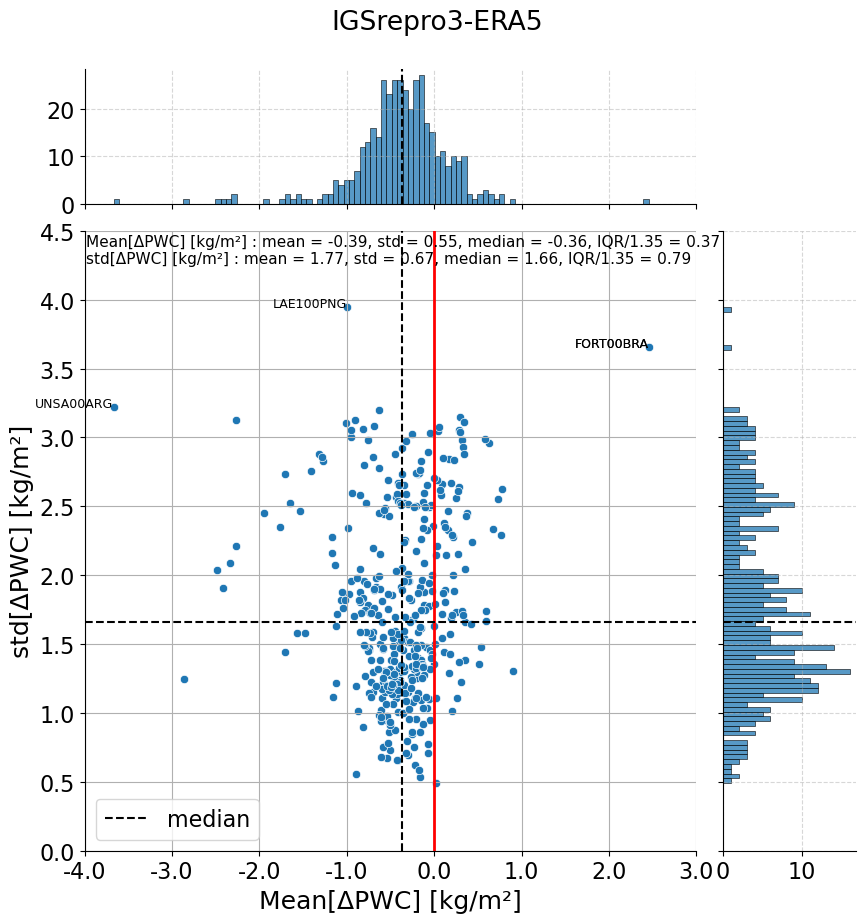

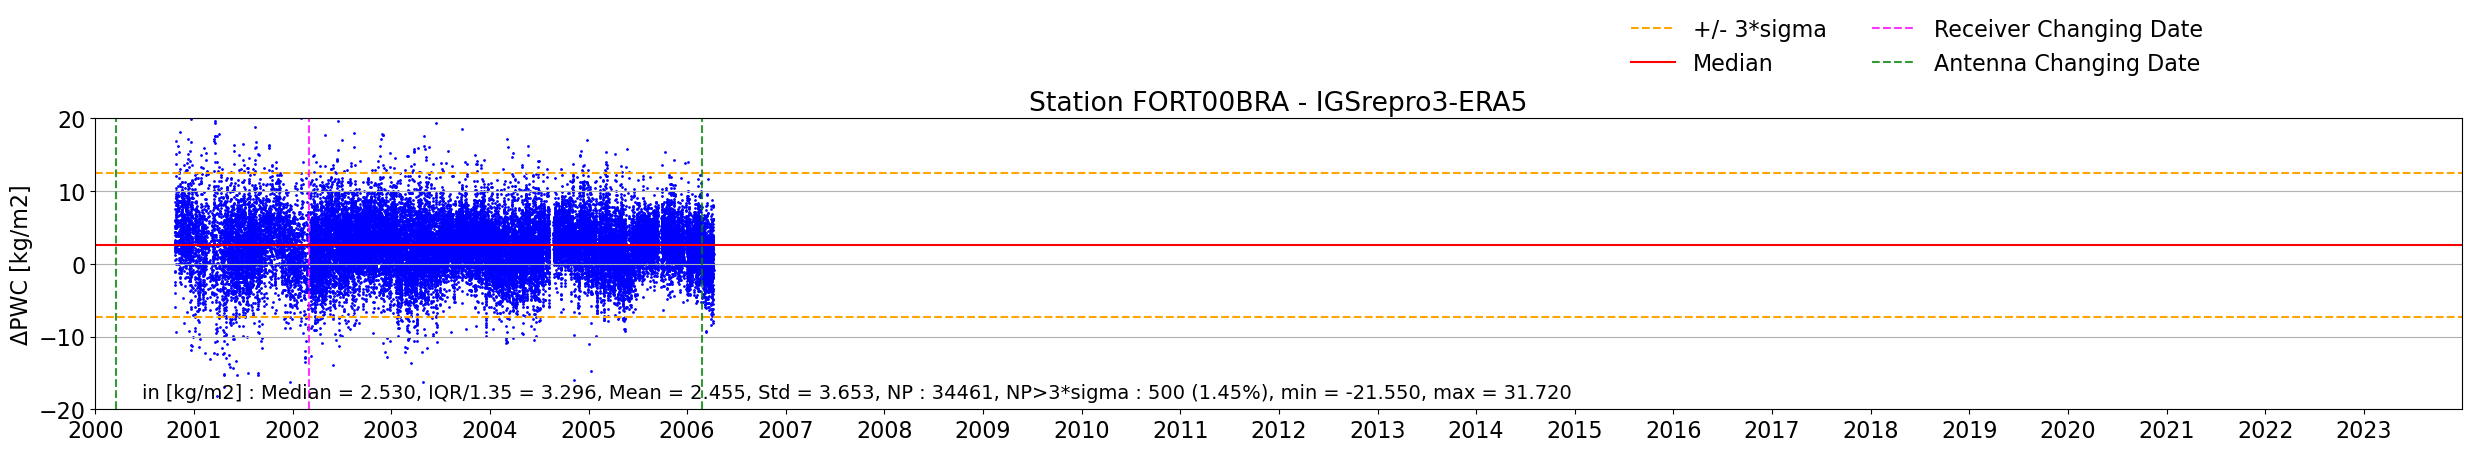

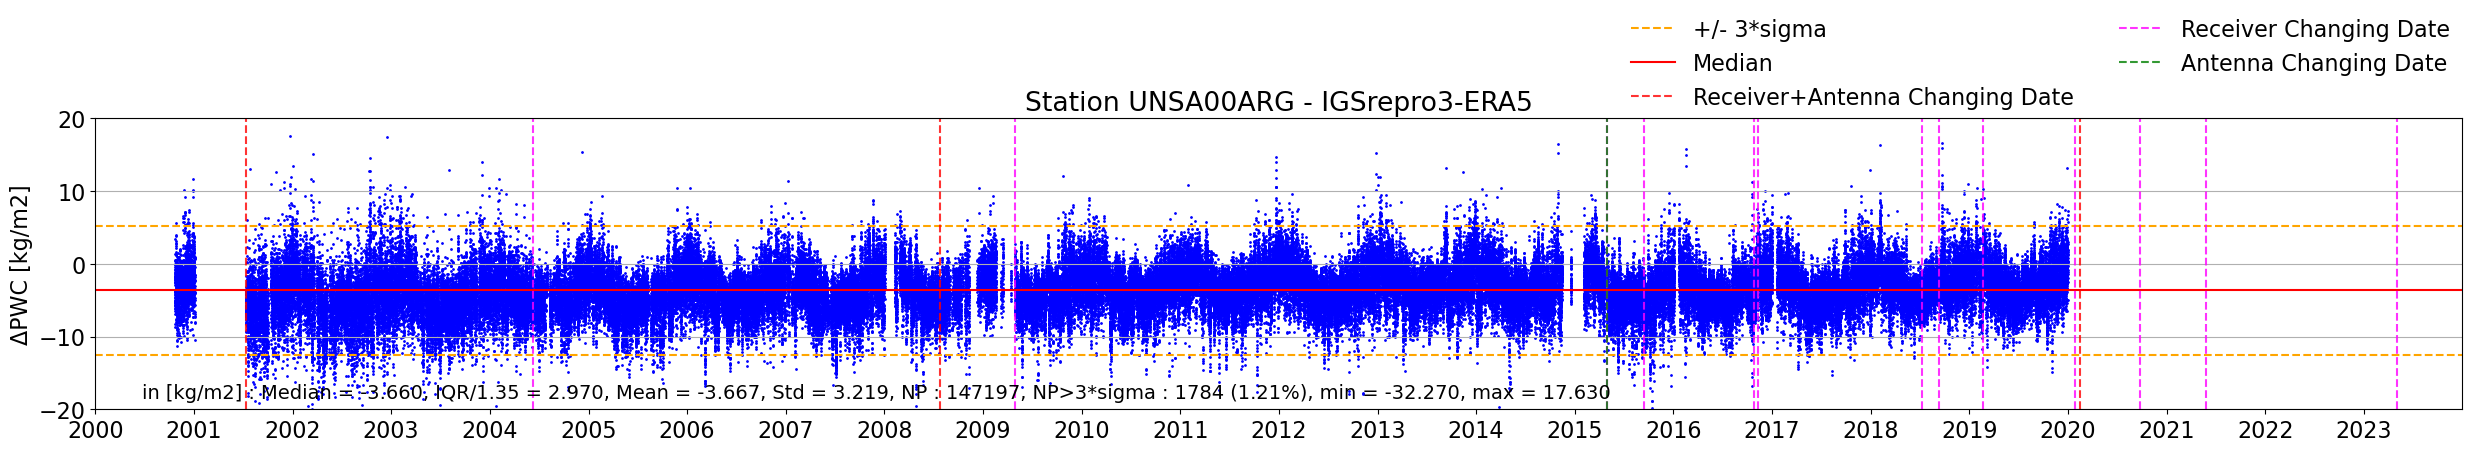

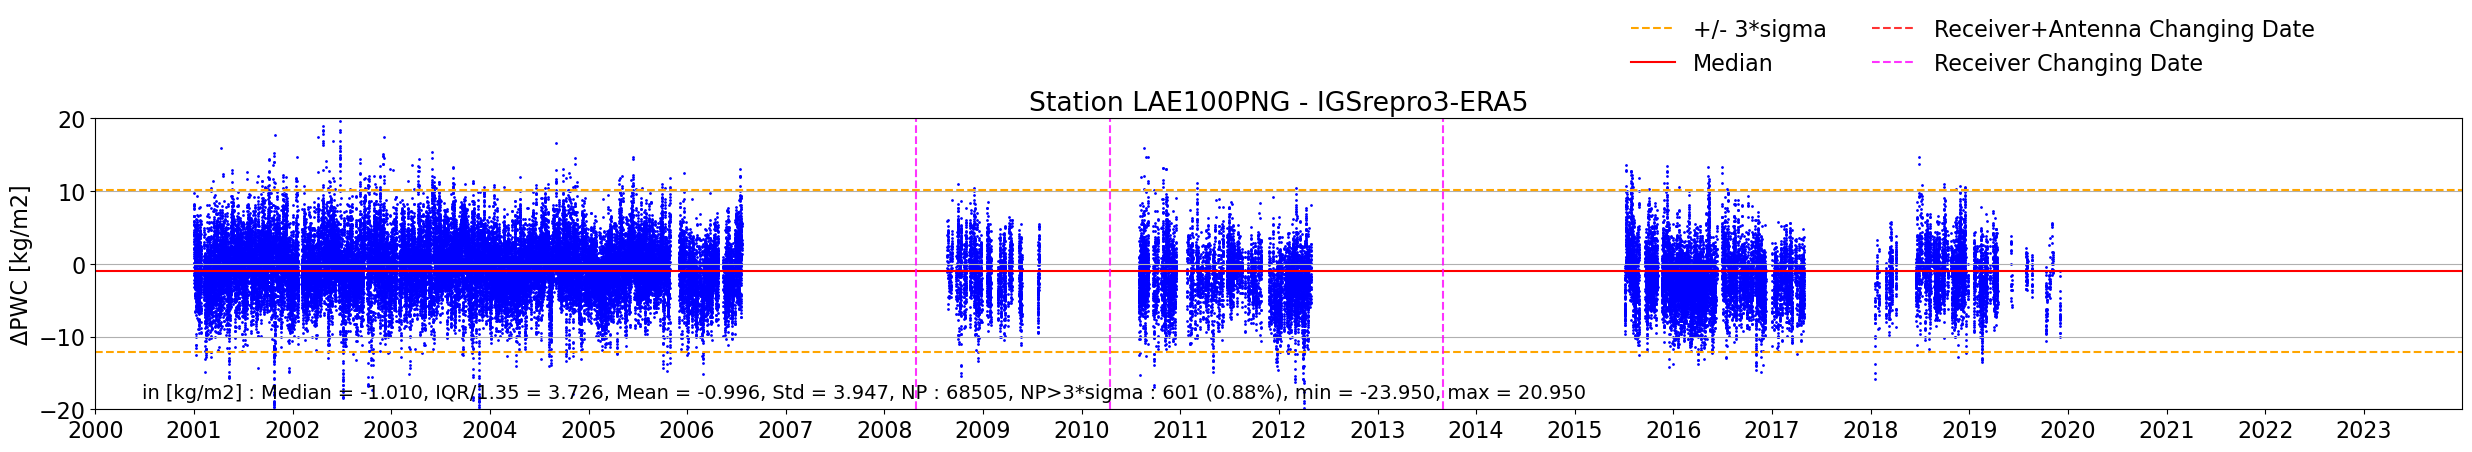

In [23]:
vf.plot_scatter_joint_stats(
    station_stats_PWC_REPRO3_ERA5,
    df_equipment,
    dataframes_dict,
    x_col="mean",
    y_col="std",
    title="IGSrepro3-ERA5",
    xlabel="Mean[ΔPWC] [kg/m²]",
    ylabel="std[ΔPWC] [kg/m²]",
    xlim=(pd.to_datetime("2000-01-01"), pd.to_datetime("2023-12-31")),
    annotate_worst=False,
    n_worst=5,
    annotate_threshold_worst=True,
    threshold_mean=(-3, 2),
    threshold_std=3.5,
    show_grid=True,
    show_stats=True,
    save=False,
    save_path=f"{base_dir}",
    dpi=600,
)

### Select your station and plot the time serie

/tmp/ipykernel_583776/4210248729.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  xlim=(pd.to_datetime("01-01-2008"), pd.to_datetime("31-12-2020")),


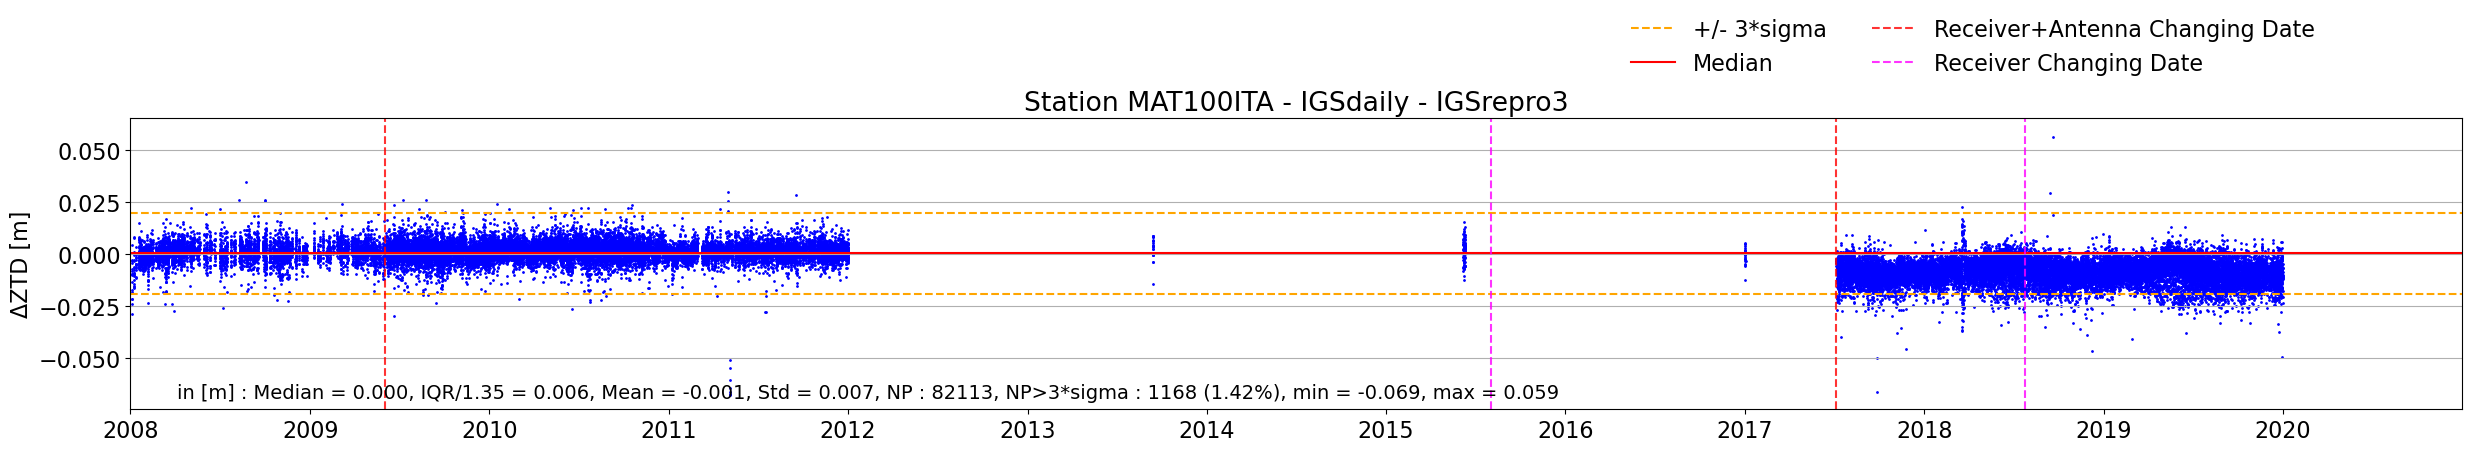

In [ ]:
vf.plot_diff_time_series(
    dataframes_dict,
    "MAT100ITA",
    "ZTD_diff",
    labels=["ΔZTD[IGSdaily-IGSrepro3]"],
    equipment_change=df_equipment,
    ylim=None,
    xlim=(pd.to_datetime("01-01-2008"), pd.to_datetime("31-12-2020")),
    save=False,
    save_path=f'{base_dir}',
    dpi=600
)

/tmp/ipykernel_583776/4134070653.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  xlim=(pd.to_datetime("01-01-2008"), pd.to_datetime("31-12-2023")),


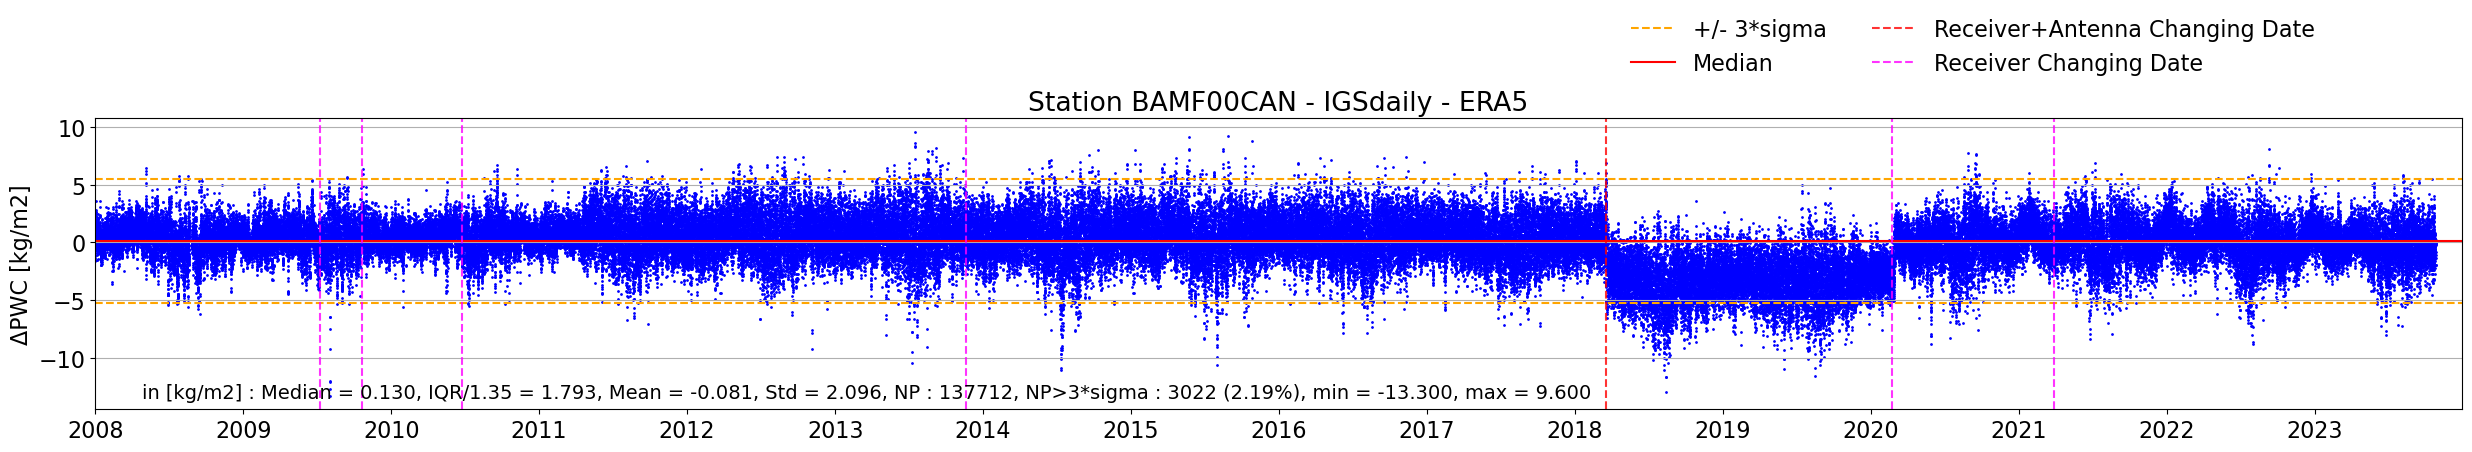

In [ ]:
vf.plot_diff_time_series(
    dataframes_dict,
    "BAMF00CAN",
    "PWC_diff",
    labels=["ΔPWC[IGSdaily-ERA5]"],
    equipment_change=df_equipment,
    ylim=None,
    xlim=(pd.to_datetime("01-01-2008"), pd.to_datetime("31-12-2023")),
    save=False,
    save_path=f'{base_dir}',
    dpi=600
)